# Telecom Churn Case Study - Sameer Kulkarni

### Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('telecom_churn_data.csv')

In [3]:
df.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.505000   
25%               0.0     93.411500     86.980500     84.126000     62.685000   
50%               0.0    197.704000    191.640000    192.080000    176.849000   
75%               0.0    371.060000    365.344500    369.370500    353.466500   
max               0.0  27731.088000  35145.834000  33543.624000  38805.617000   

        onnet_mou_6      ...        sachet_3g_9     fb_user_6     fb_user_7  \
count  96062.000000      ...       99999.000000  25153.000000  25571.000000   
mean     132.395875      ...           0.084581      0.914404      0.908764   
std      297.207406      ...           0.650457      0.279772      0.287950   
min        0.000000      ...           0.000000      0.000000      0.000000   
25%        7.380000      ...           0.000000      1.000000      1.000000   
50%       34.310000      ...           0.000000      1.000000      1.000000   
75%      118.740000      ...           0.000000      1.000000      1.000000   
max     7376.710000      ...          49.000000      1.000000      1.000000   

          fb_user_8     fb_user_9           aon    aug_vbc_3g    jul_vbc_3g  \
count  26339.000000  25922.000000  99999.000000  99999.000000  99999.000000   
mean       0.890808      0.860968   1219.854749     68.170248     66.839062   
std        0.311885      0.345987    954.733842    267.580450    271.201856   
min        0.000000      0.000000    180.000000      0.000000      0.000000   
25%        1.000000      1.000000    467.000000      0.000000      0.000000   
50%        1.000000      1.000000    863.000000      0.000000      0.000000   
75%        1.000000      1.000000   1807.500000      0.000000      0.000000   
max        1.000000      1.000000   4337.000000  12916.220000   9165.600000   

         jun_vbc_3g    sep_vbc_3g  
count  99999.000000  99999.000000  
mean      60.021204      3.299373  
std      253.938223     32.408353  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max    11166.210000   2618.570000  

[8 rows x 214 columns]

In [4]:
df.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [5]:
#Getting single value columns
drop_cols = list(filter(lambda x : len(df[x].value_counts()) < 2, df.columns))

In [6]:
#dropping these columns as these are one value or null value
df.drop(drop_cols,axis=1, inplace=True)

In [7]:
#Renaming columns for more clarity
df.rename(columns={'jun_vbc_3g': 'vbc_3g_6',
                                'jul_vbc_3g': 'vbc_3g_7',
                                'aug_vbc_3g': 'vbc_3g_8',
                                'sep_vbc_3g': 'vbc_3g_9'
                               }, inplace=True)

In [8]:
# DF for only the 9th month data for labelling as churn or not
churn_month = df.loc[:,['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']]
churners = pd.DataFrame()
churners =df.loc[(churn_month.total_ic_mou_9 == 0.00) 
                    & (churn_month.total_og_mou_9 == 0.00)
                    & (churn_month.vol_2g_mb_9 == 0.00)
                    & (churn_month.vol_3g_mb_9 == 0.00), ['mobile_number']
                   ]
churners['churn'] = 1

df = pd.merge(df, churners, how='outer', on='mobile_number')
df['churn'] = df['churn'].fillna(0)
df['churn'] = df['churn'].astype(int)
mont_9_columns = list(map(lambda x : x.endswith('_9'),df.columns))
df.drop(df.loc[:,mont_9_columns],axis = 1, inplace=True)


In [9]:
# Filter for High Value Customers
df['d_av_rech_amt'] = round((df['total_rech_amt_6'] + df['total_rech_amt_7'])/2,2)
df['d_av_rech_amt_data'] = round((df['av_rech_amt_data_6']+df['av_rech_amt_data_7'])/2,2)
df = df.loc[(df['d_av_rech_amt'] > df['d_av_rech_amt'].quantile(0.70)) |
(df['d_av_rech_amt_data'] > df['d_av_rech_amt_data'].quantile(0.70))]
df.drop(['d_av_rech_amt','d_av_rech_amt_data'], axis=1, inplace=True)

In [10]:
# Removing all records that have negative values in Revenue columns of Call usage.
df = df.loc[(df.arpu_6 > 0) & (df.arpu_7 > 0) & (df.arpu_8 >0)]

In [11]:
#imputing value for night pack users
df['night_pck_user_6'] =df.loc[:,'night_pck_user_6'].fillna(-1).astype(int)
df['night_pck_user_7'] =df.loc[:,'night_pck_user_7'].fillna(-1).astype(int)
df['night_pck_user_8'] =df.loc[:,'night_pck_user_8'].fillna(-1).astype(int)

In [12]:
#imputing value for fb users
df['fb_user_6'] =df.loc[:,'fb_user_6'].fillna(-1).astype(int)
df['fb_user_7'] =df.loc[:,'fb_user_7'].fillna(-1).astype(int)
df['fb_user_8'] =df.loc[:,'fb_user_8'].fillna(-1).astype(int)

In [13]:
# percentage of missing values in each column
round(df.isnull().sum()/len(df.index), 2)*100

mobile_number        0.0
arpu_6               0.0
arpu_7               0.0
arpu_8               0.0
onnet_mou_6          1.0
onnet_mou_7          1.0
onnet_mou_8          1.0
offnet_mou_6         1.0
offnet_mou_7         1.0
offnet_mou_8         1.0
roam_ic_mou_6        1.0
roam_ic_mou_7        1.0
roam_ic_mou_8        1.0
roam_og_mou_6        1.0
roam_og_mou_7        1.0
roam_og_mou_8        1.0
loc_og_t2t_mou_6     1.0
loc_og_t2t_mou_7     1.0
loc_og_t2t_mou_8     1.0
loc_og_t2m_mou_6     1.0
loc_og_t2m_mou_7     1.0
loc_og_t2m_mou_8     1.0
loc_og_t2f_mou_6     1.0
loc_og_t2f_mou_7     1.0
loc_og_t2f_mou_8     1.0
loc_og_t2c_mou_6     1.0
loc_og_t2c_mou_7     1.0
loc_og_t2c_mou_8     1.0
loc_og_mou_6         1.0
loc_og_mou_7         1.0
                    ... 
vol_3g_mb_8          0.0
arpu_3g_6           58.0
arpu_3g_7           57.0
arpu_3g_8           57.0
arpu_2g_6           58.0
arpu_2g_7           57.0
arpu_2g_8           57.0
night_pck_user_6     0.0
night_pck_user_7     0.0


In [14]:
#Fill null values with 0
df.fillna(0,inplace=True)

In [15]:
df.shape

(30343, 159)

##### EDA
##### Checking if all the rows are unique. Mobile number is the Unique , as no duplicate rows were found

In [16]:
# Getting unique count, sorting in descending order and getting top 10 items
df.mobile_number.value_counts().sort_values(ascending = False)[0:10]

7000883200    1
7000934425    1
7000346682    1
7002376249    1
7001344001    1
7000891396    1
7001292808    1
7001557001    1
7000971275    1
7001366540    1
Name: mobile_number, dtype: int64

In [17]:
df.iloc[:,0:50].info()
df.iloc[:,50:100].info()
df.iloc[:,100:160].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30343 entries, 0 to 99997
Data columns (total 50 columns):
mobile_number       30343 non-null int64
arpu_6              30343 non-null float64
arpu_7              30343 non-null float64
arpu_8              30343 non-null float64
onnet_mou_6         30343 non-null float64
onnet_mou_7         30343 non-null float64
onnet_mou_8         30343 non-null float64
offnet_mou_6        30343 non-null float64
offnet_mou_7        30343 non-null float64
offnet_mou_8        30343 non-null float64
roam_ic_mou_6       30343 non-null float64
roam_ic_mou_7       30343 non-null float64
roam_ic_mou_8       30343 non-null float64
roam_og_mou_6       30343 non-null float64
roam_og_mou_7       30343 non-null float64
roam_og_mou_8       30343 non-null float64
loc_og_t2t_mou_6    30343 non-null float64
loc_og_t2t_mou_7    30343 non-null float64
loc_og_t2t_mou_8    30343 non-null float64
loc_og_t2m_mou_6    30343 non-null float64
loc_og_t2m_mou_7    30343 non-nul

### Understanding Data : Univariate Analysis on Numeric Variables

In [18]:
print('Metrics - Numeric Variables')

df_numeric = (df.iloc[:,0:20])._get_numeric_data()
print(df_numeric.describe())

df_numeric = (df.iloc[:,20:40])._get_numeric_data()
print(df_numeric.describe())
  
df_numeric = (df.iloc[:,40:60])._get_numeric_data()
print(df_numeric.describe())

df_numeric = (df.iloc[:,60:80])._get_numeric_data()
print(df_numeric.describe())

df_numeric = (df.iloc[:,80:100])._get_numeric_data()
print(df_numeric.describe())

df_numeric = (df.iloc[:,100:120])._get_numeric_data()
print(df_numeric.describe())

df_numeric = (df.iloc[:,120:140])._get_numeric_data()
print(df_numeric.describe())

df_numeric = (df.iloc[:,140:160])._get_numeric_data()
print(df_numeric.describe())

Metrics - Numeric Variables
       mobile_number        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count   3.034300e+04  30343.000000  30343.000000  30343.000000  30343.000000   
mean    7.001224e+09    567.181066    578.277537    534.774667    280.637214   
std     6.832551e+05    427.968625    457.995911    482.392632    449.174770   
min     7.000000e+09      0.040000      0.020000      0.010000      0.000000   
25%     7.000645e+09    348.105000    354.232500    288.595500     34.610000   
50%     7.001236e+09    477.291000    482.293000    447.185000    115.610000   
75%     7.001813e+09    680.429500    688.561500    664.236000    330.785000   
max     7.002411e+09  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  30343.000000  30343.000000  30343.000000  30343.000000  30343.000000   
mean     293.103975    262.371072    396.131476    408.956529    368.288698   
std      475.2

       loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  \
count      30343.000000      30343.000000      30343.000000      30343.000000   
mean         154.851849         15.682761         16.681662         15.017354   
std          216.369755         45.791973         49.762630         44.073627   
min            0.000000          0.000000          0.000000          0.000000   
25%           31.985000          0.000000          0.000000          0.000000   
50%           90.940000          2.030000          2.330000          2.060000   
75%          197.235000         12.630000         13.280000         12.090000   
max         5738.460000       1678.410000       1983.010000       1588.530000   

       loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  std_ic_t2t_mou_6  \
count  30343.000000  30343.000000  30343.000000      30343.000000   
mean     240.660664    246.932202    236.607998         15.754567   
std      307.565274    315.653289    307.230184         78.3131

       count_rech_3g_8  av_rech_amt_data_6  av_rech_amt_data_7  \
count     30343.000000        30343.000000        30343.000000   
mean          0.356029          102.139136          110.686684   
std           1.201185          194.451037          203.719627   
min           0.000000            0.000000            0.000000   
25%           0.000000            0.000000            0.000000   
50%           0.000000            0.000000            0.000000   
75%           0.000000          154.000000          171.000000   
max          45.000000         7546.000000         4365.000000   

       av_rech_amt_data_8   vol_2g_mb_6   vol_2g_mb_7   vol_2g_mb_8  \
count        30343.000000  30343.000000  30343.000000  30343.000000   
mean           101.602853     87.856198     87.515468     77.376706   
std            191.753531    292.675026    292.965371    278.627837   
min              0.000000      0.000000      0.000000      0.000000   
25%              0.000000      0.000000      0.000

In [19]:
#checking data imbalance for churn
100.*(df['churn'] == 1).sum()/len(df.index)

6.179349438091157

## EDA - Observations and Implementation

Cleaing the data is going to be our first step, Dataset has lot of Numeric datatype columns and also has few date datatype columns. 

#### Churn as Dependent Variable

> There is class Imbalance in the dataset, where churn customers are only 6% of the dataset.


#### Fields that are impacting revenue (No of Column - 3 ):

> Invalid and Negative values indicates few customers are making loss to the company. We are going to drop these columns as either they invalid or not adding importance to our  future prediction hence can be dropped from the data.

> Data Standardization: These revenue cols are rounded to 2 decimal places.


#### Recharge (3 Date cols and 12 Numeric Cols )

Data Type Conversion: 

> Data in numeric columns are in integers, so converted to int type.
> Date columns have been converted to date type


#### Data realted to 2G And 3G  (nearly 22 Columns)

> Most of the columns have median as '0' and have outliers, renaming vbc_3g columns need by adding month as nunmber and Standardization: Columns are rounded off to 2 decimal places.

#### Call Usage( Nearly 60 cols):

> Call usage minutes is generally 0 except for few outliers, for below variables:  Incoming ISD,  Incoming Others, STD incoming T2F, ISD Outgoing, Roaming, Local Outgoing T2C (Customer care calls), Incoming Special, STD outgoing T2F, Outgoing Others.

> Applying Aggregation to Columns based on Incoming and Outgoing, or Aggregation based on Each Type of Incoming Calls and Outgoing Calls and looking at the metrics will give a better understanding of the data.

#### Age on Network ( AON - 1 Column) 

> Feature has been derived from AON column.

#### Review the dropped cols:

> More columns will be lost if we drop cols with missing values, while this can handled by imputing 0, as missing values have a pattern where user calls have blanks for Data related cols and vice-versa.

#### Feature Engineering - Observations
> Get no. of years the customer is using current Network - AON
> Deriving fields which indicate the type of user a customer is: using both Calls and Data, Only Calls, Only Data, Only Incoming calls, Only Outgoing calls, .. 
> Bin/club the customers into different segments based on their recharge amount, Usage/Recharge pattern and Service usage.
> Calls made to Customer Care is a Key indicator that customer is unhappy with the services, derive cols like 'time over call



In [20]:
def plot_box(df, numeric_val):
    sns.boxplot(y=df[numeric_val])
    plt.title("Distribution of "+ numeric_val)
    plt.show()

In [21]:
def plot_by_grouped_barcharts(df_seg,label,showsize=10):
        colors = ['green', 'red']
        ax=df_seg.plot(kind='bar',figsize=(15,10),color=colors)
        ax.set_xlabel(label, fontsize=12)
        ax.set_ylabel("Churn", fontsize=12)
        plt.show()
        return

In [22]:
def plot_by_seg_numbins(col,new_bin_column_name,y_col_name,binval,showsize=10):
        df[new_bin_column_name] = pd.cut(df[col], binval)
        df_num_col_status=df.pivot_table(values=[y_col_name],index=[new_bin_column_name],aggfunc='mean')
        df_num_col_status.head(showsize)
        return df_num_col_status

In [23]:
def create_bin(col,new_bin_column_name,binval):
    df[new_bin_column_name] = pd.cut(df[col], binval)
    return df

In [24]:
def plot_continuous_var_boxPlot(df,param1):
    not_churn_df=df[df.churn == 0]
    churn_df=df[df.churn  == 1]
    
    plt.figure(figsize=(20, 10)) 
    plt.subplot(1,2,1)
    sns.boxplot(y=not_churn_df[param1])
    plt.title(param1 +' distribution for Not Churned ',fontsize=20)
    
    plt.subplot(1,2,2)
    sns.boxplot(y=churn_df[param1])
    plt.title(param1 +' distribution for Churned ',fontsize=20)
    plt.show()

In [25]:
def plot_for_seg_univariate(col_name,y_col_name,df_seg):
    plt.suptitle('Segmented Univariate Analysis (' + col_name + ')', fontsize=24)
    plt.rc("font", size=10)
    plt.figure(figsize=(20, 10))
    sns.barplot(x=df_seg.index, y=y_col_name, data=df_seg)
    plt.title('Age vs Average revenue ' + col_name)
    plt.xlabel(col_name,rotation=0, fontsize=20, labelpad=20)
    plt.xticks(rotation=45,fontsize=10)
    plt.ylabel('Age to Average revenue  ',rotation=90, fontsize=20, labelpad=20)
    plt.show()
    return

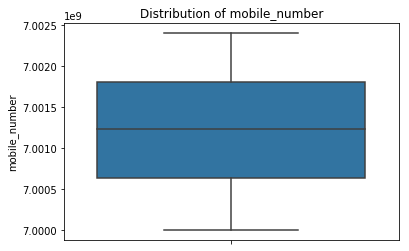

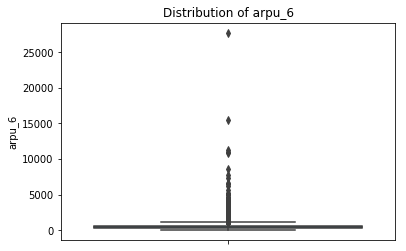

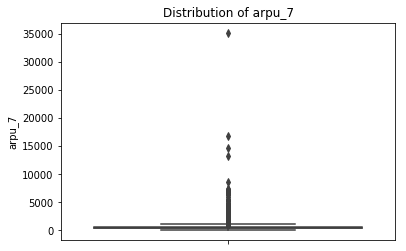

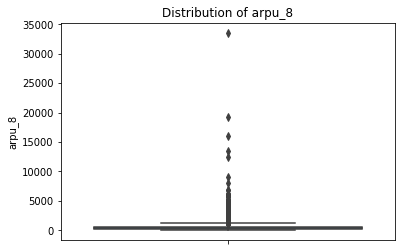

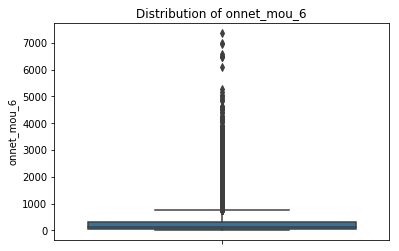

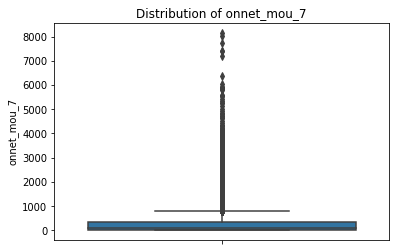

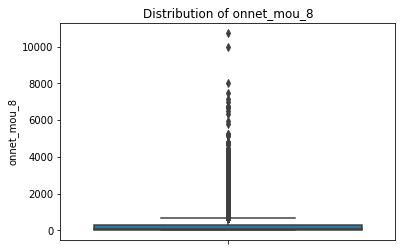

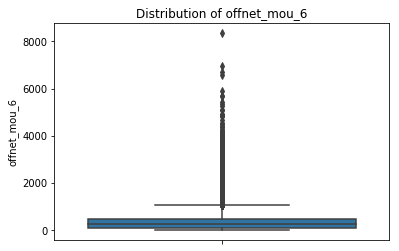

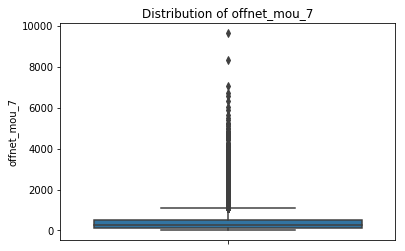

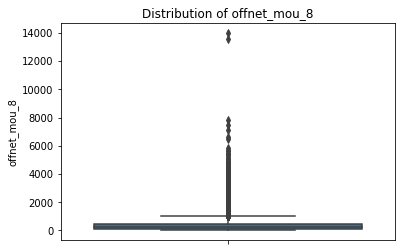

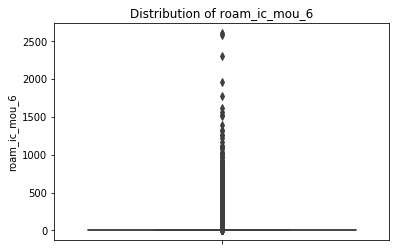

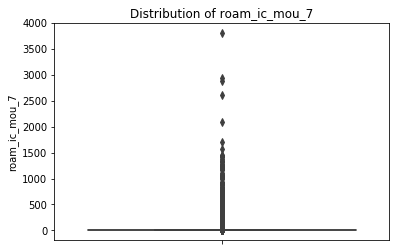

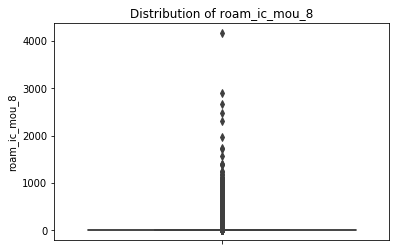

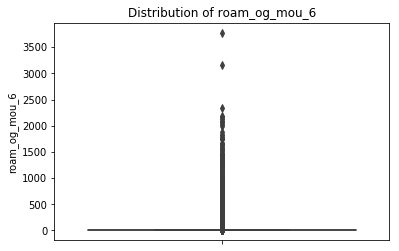

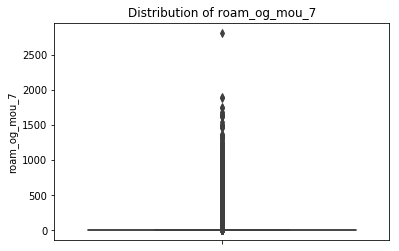

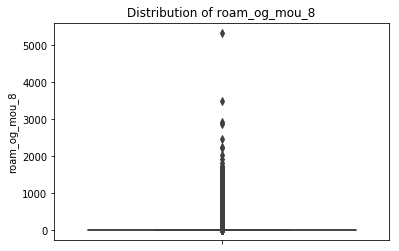

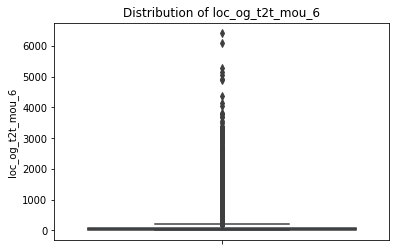

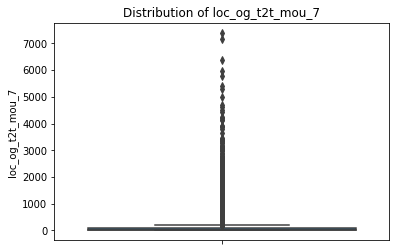

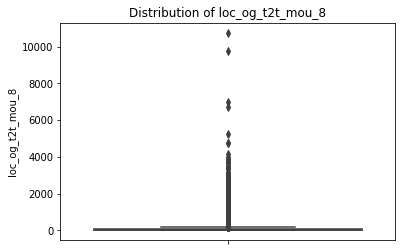

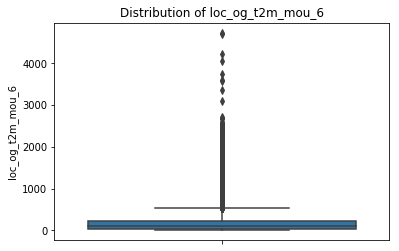

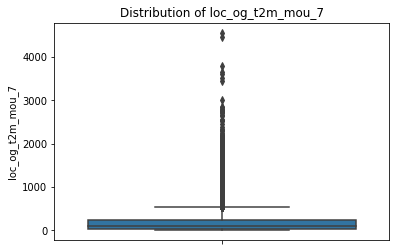

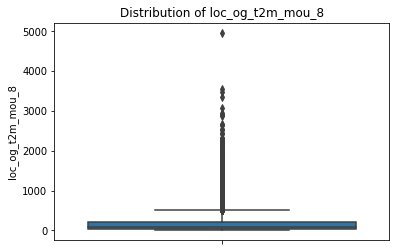

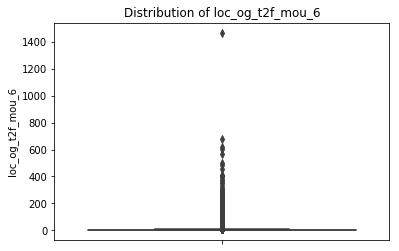

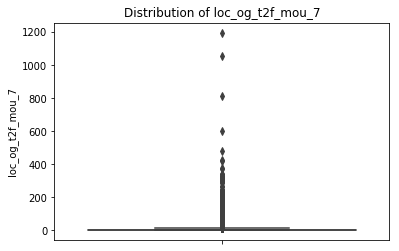

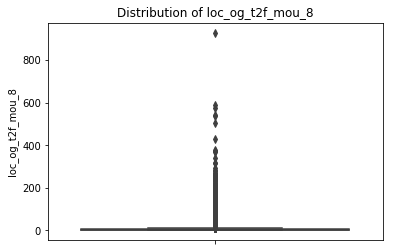

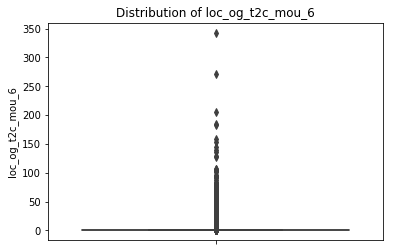

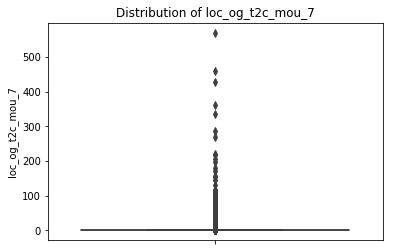

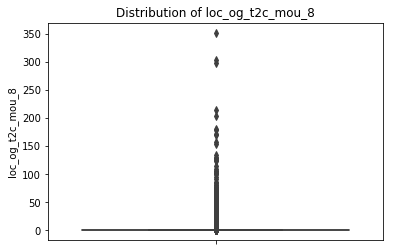

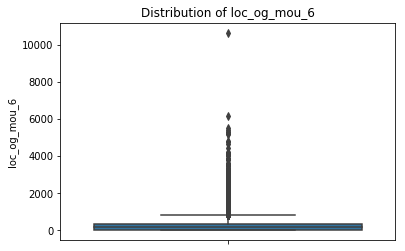

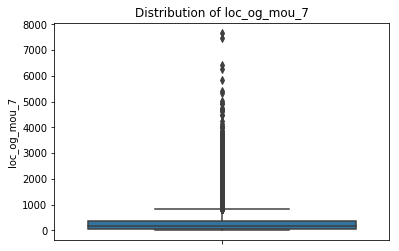

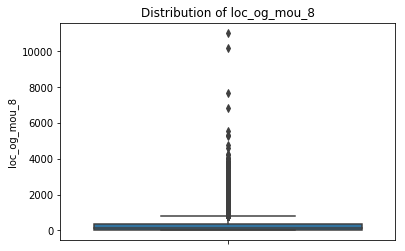

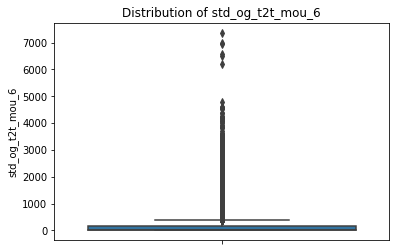

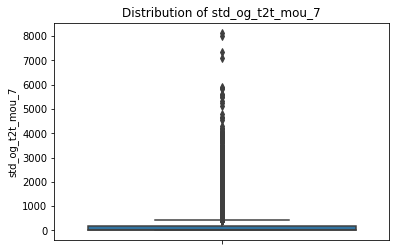

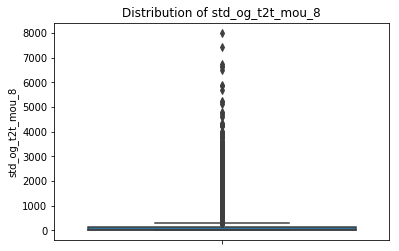

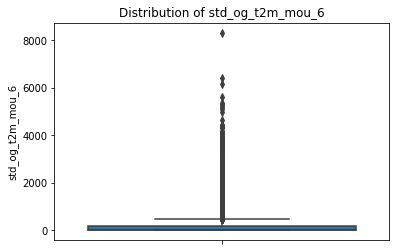

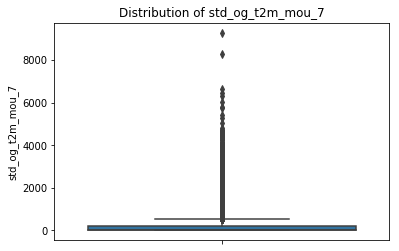

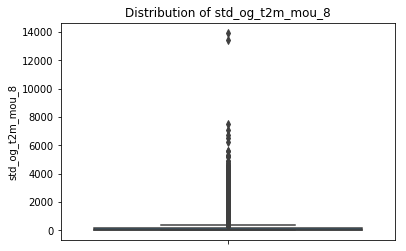

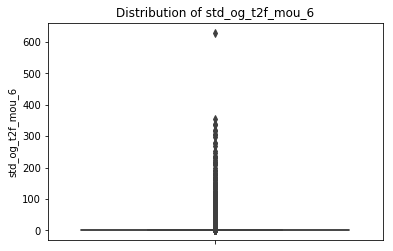

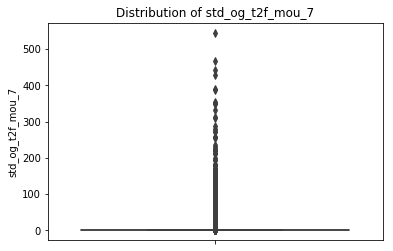

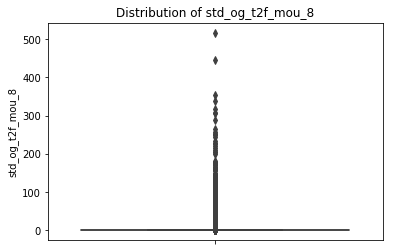

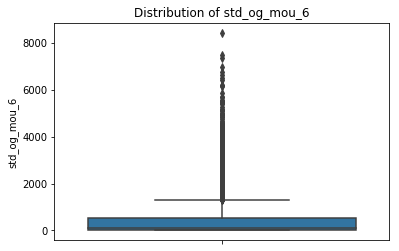

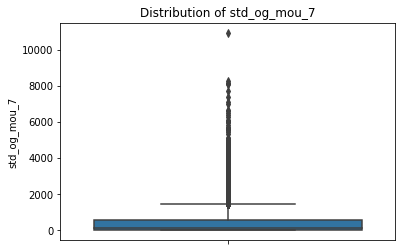

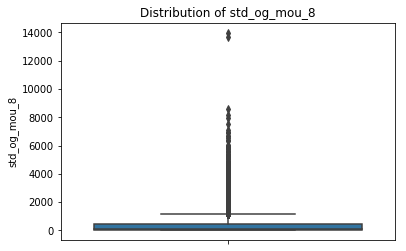

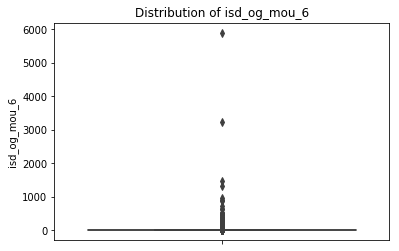

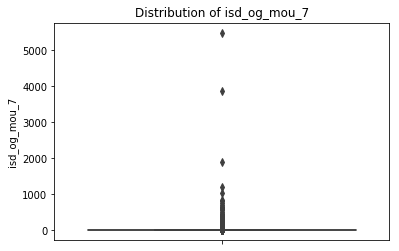

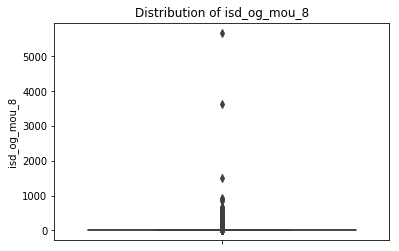

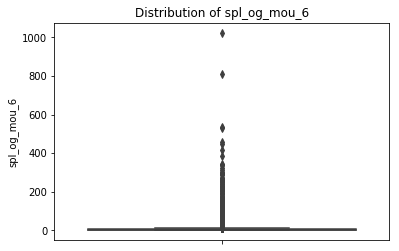

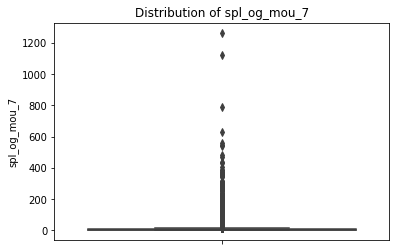

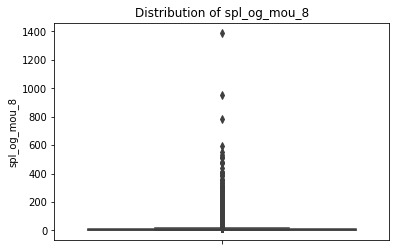

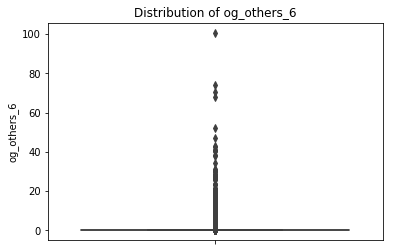

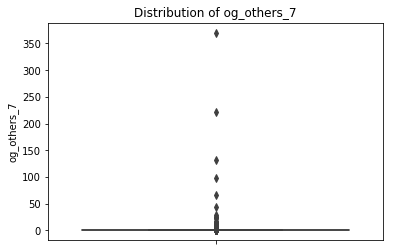

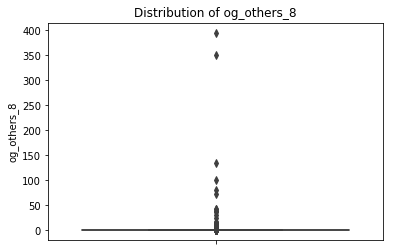

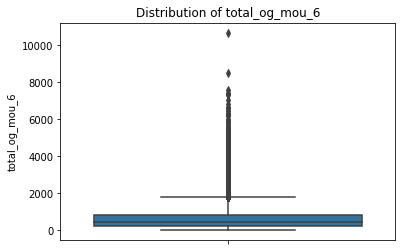

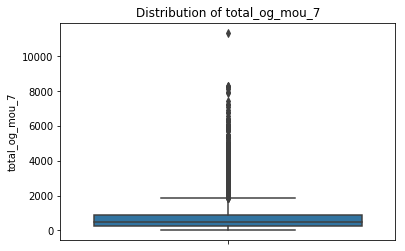

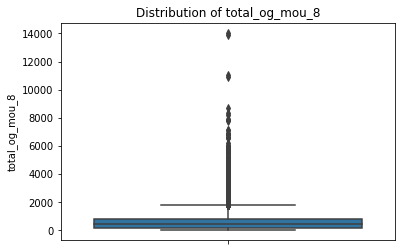

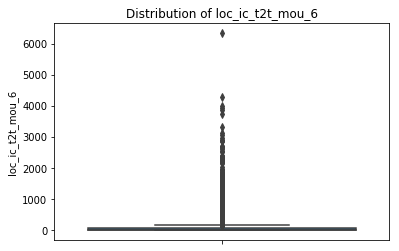

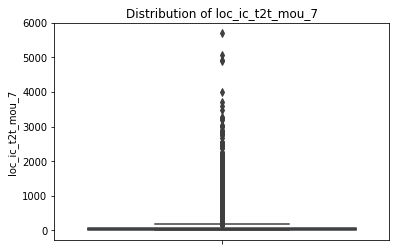

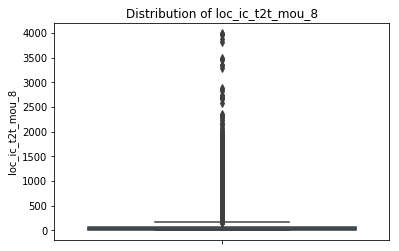

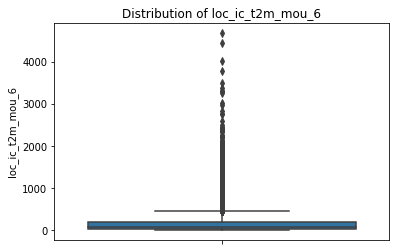

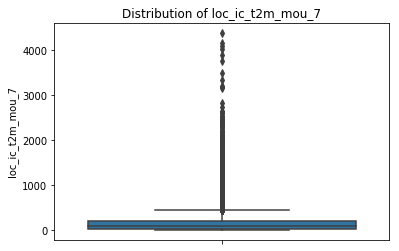

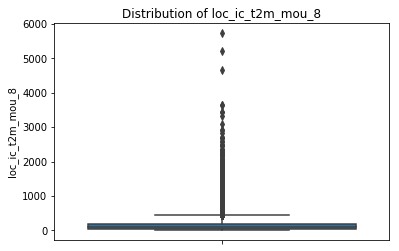

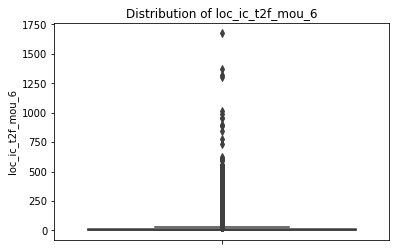

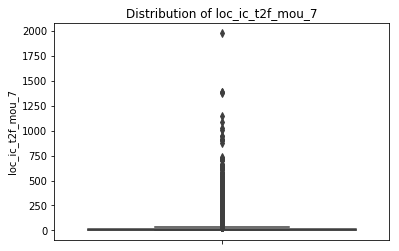

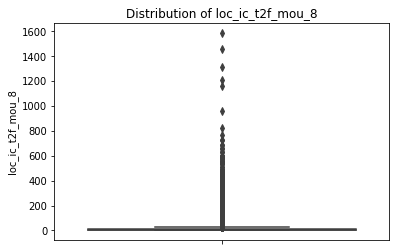

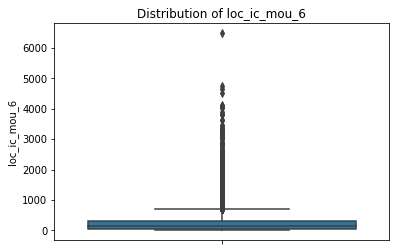

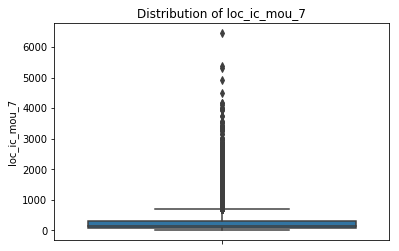

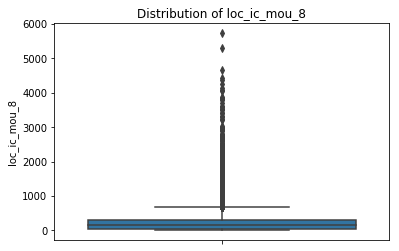

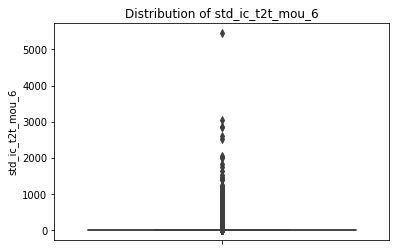

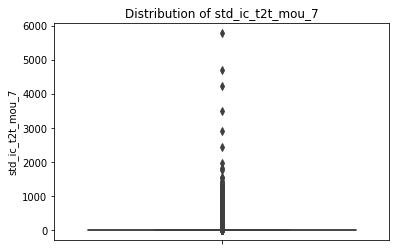

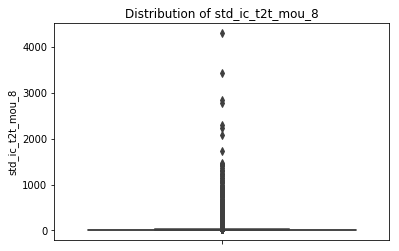

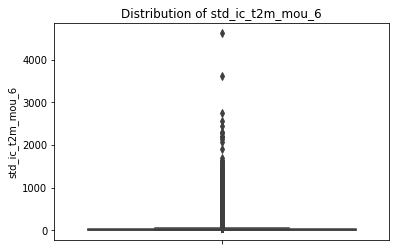

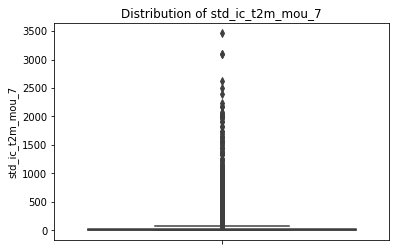

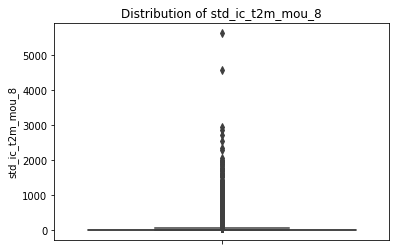

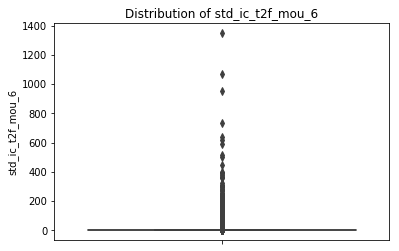

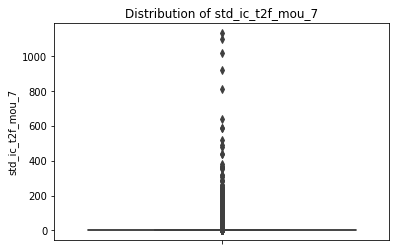

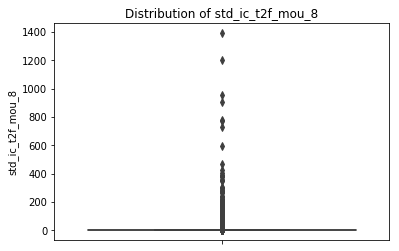

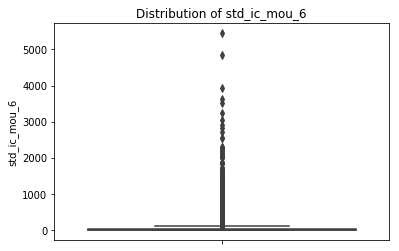

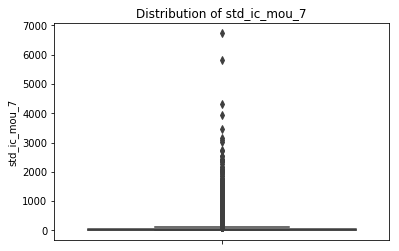

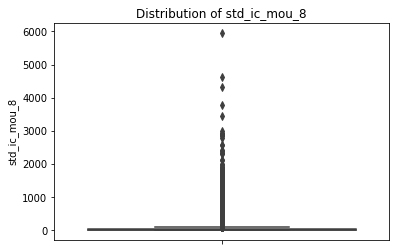

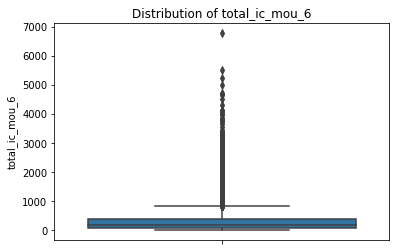

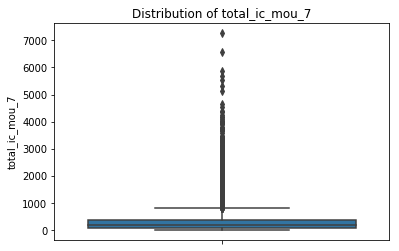

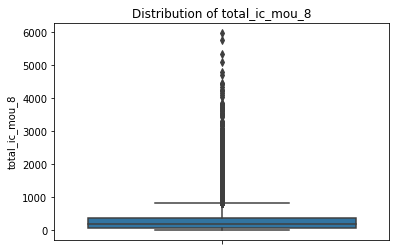

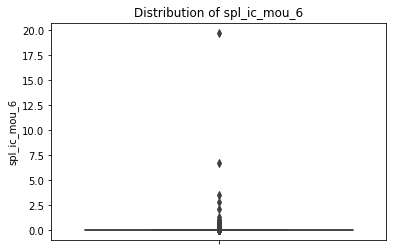

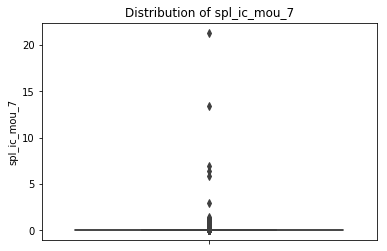

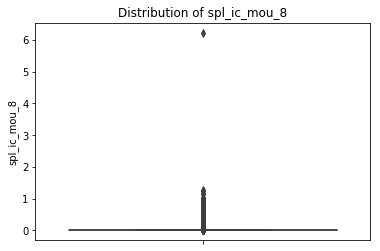

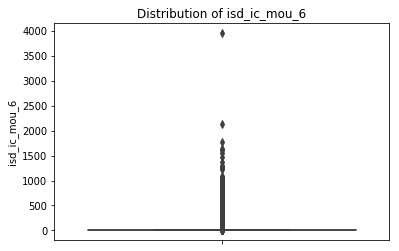

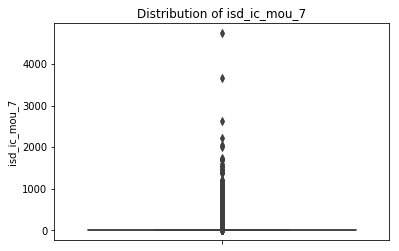

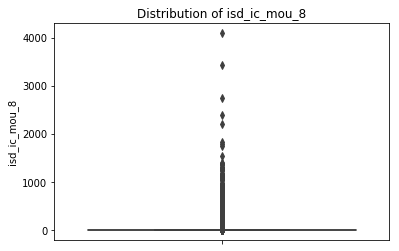

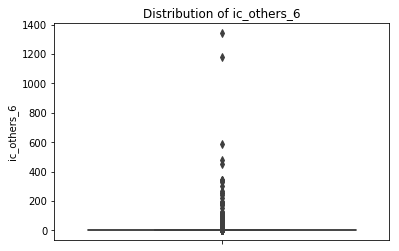

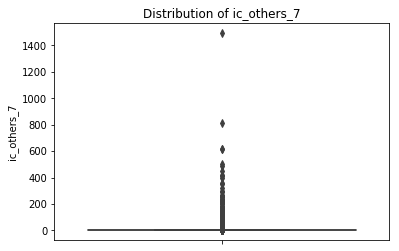

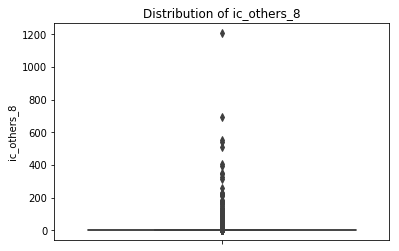

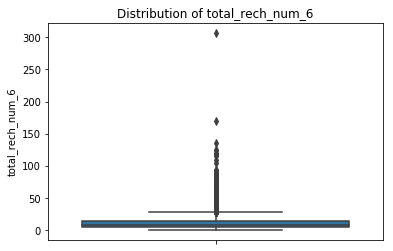

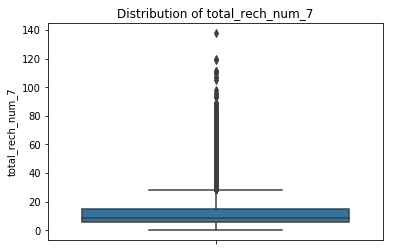

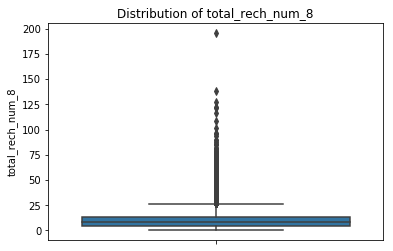

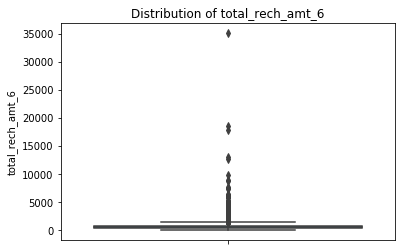

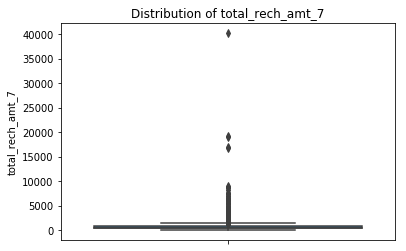

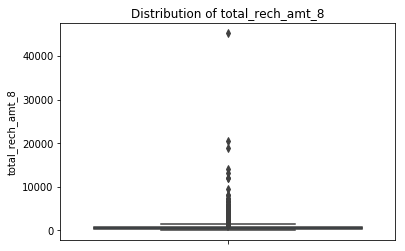

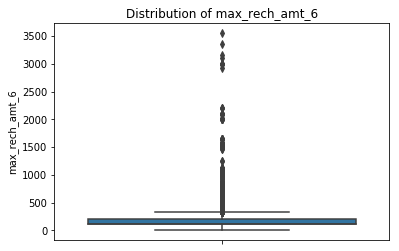

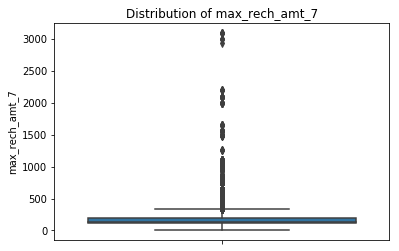

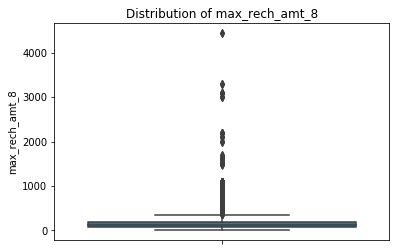

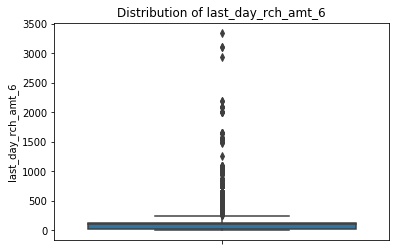

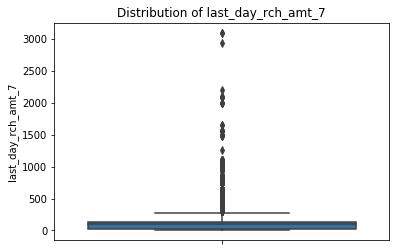

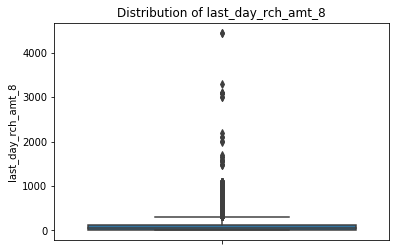

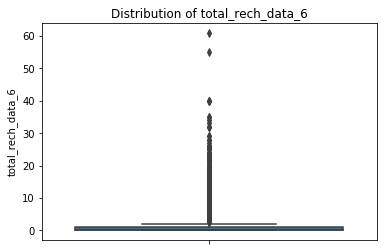

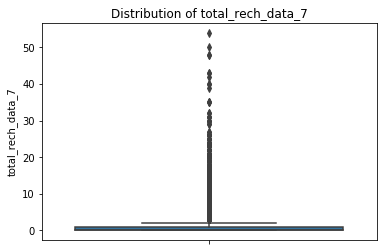

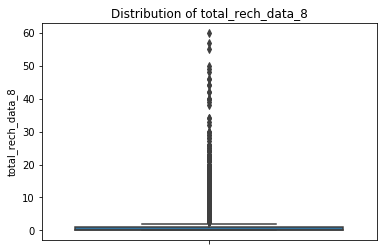

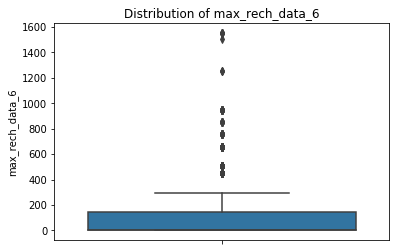

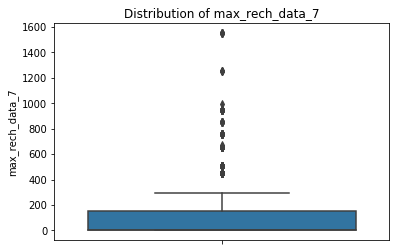

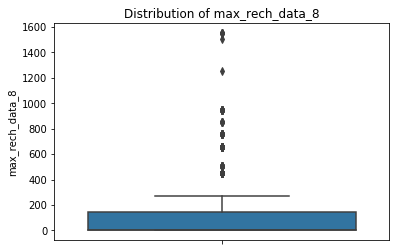

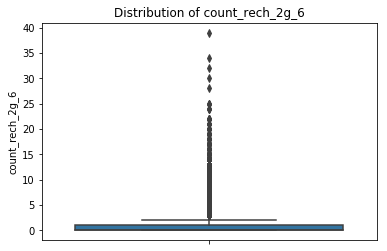

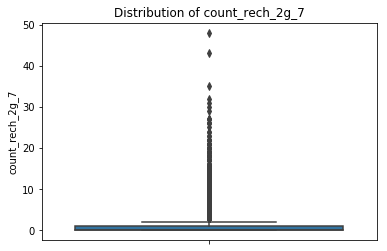

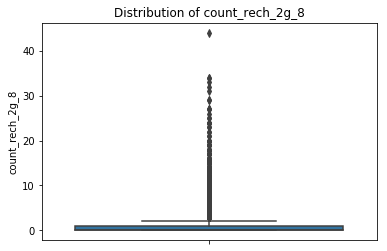

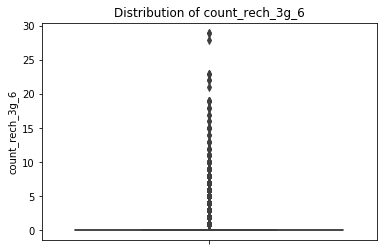

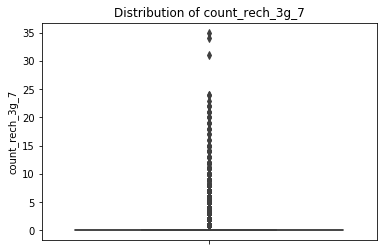

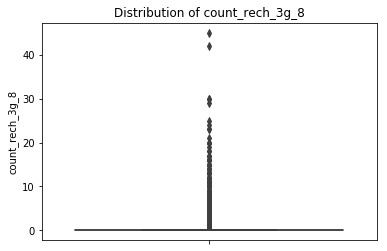

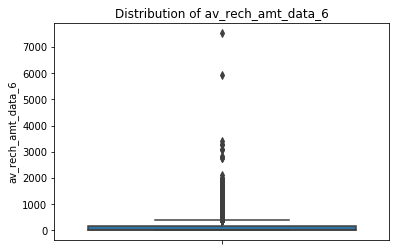

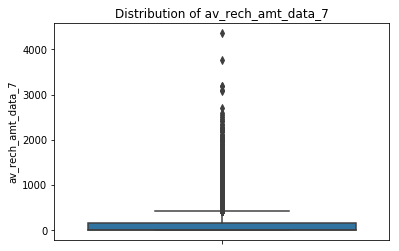

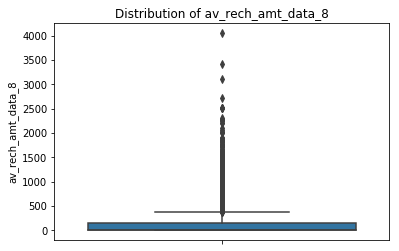

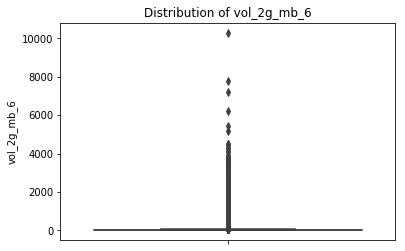

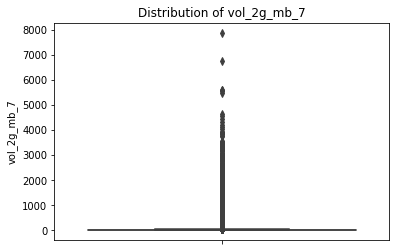

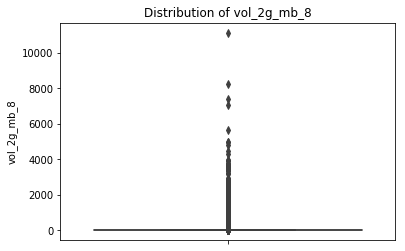

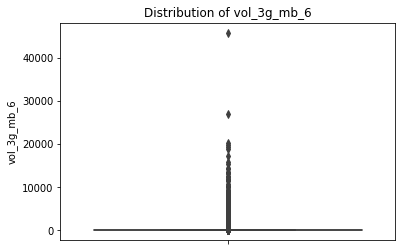

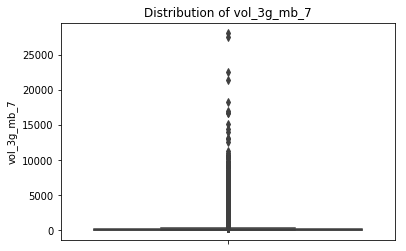

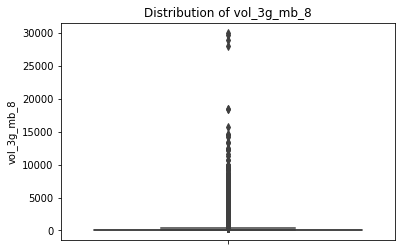

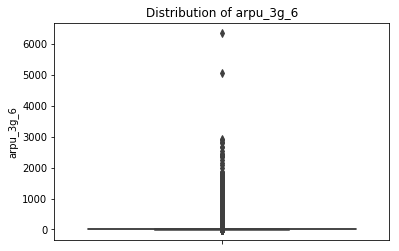

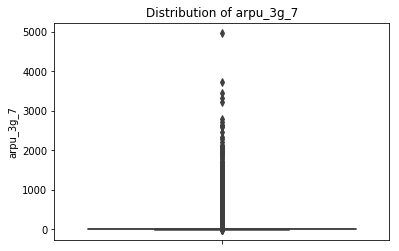

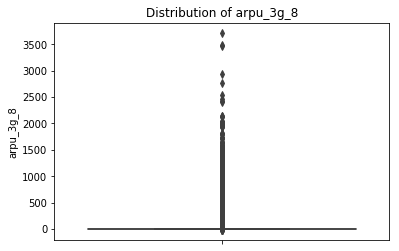

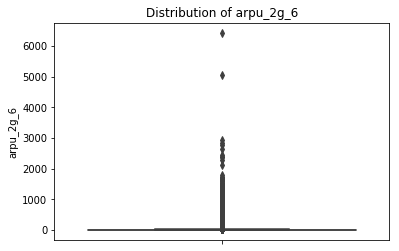

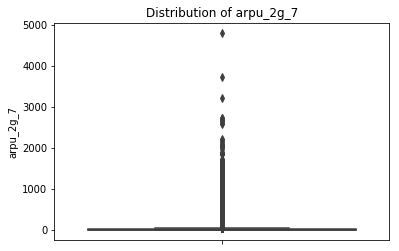

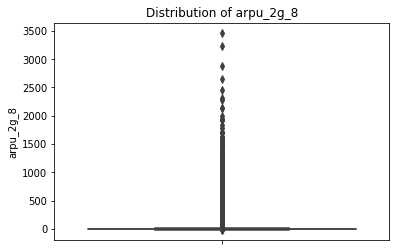

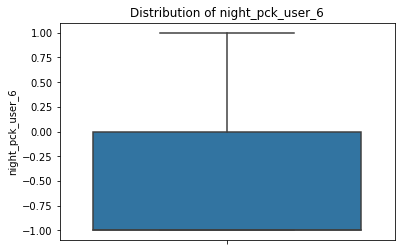

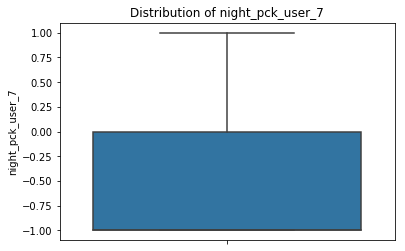

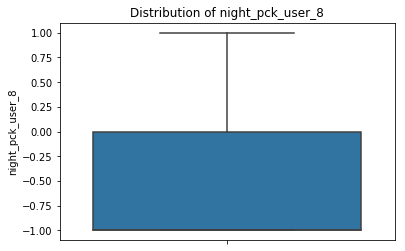

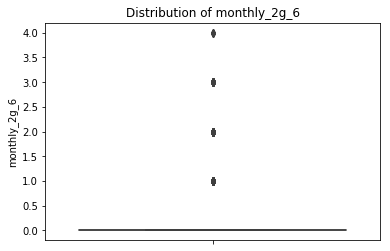

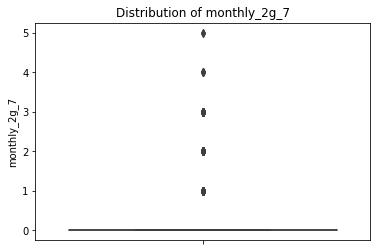

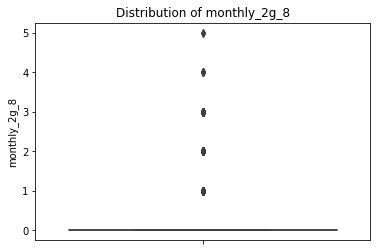

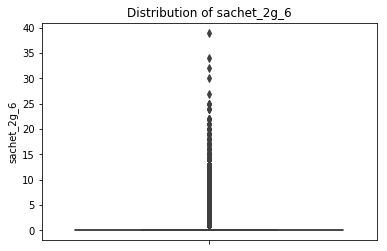

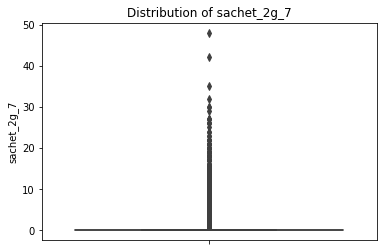

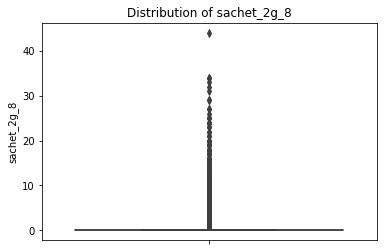

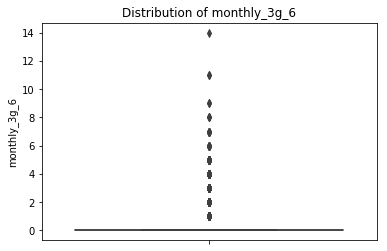

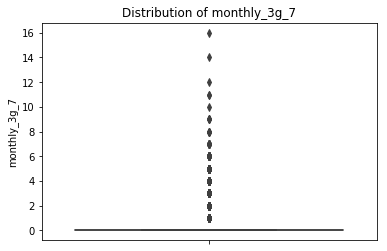

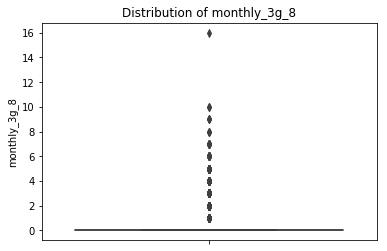

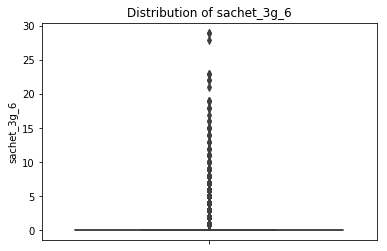

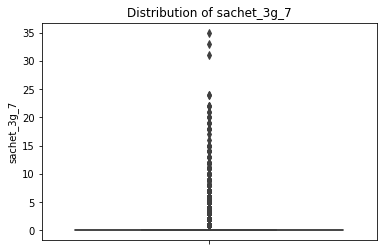

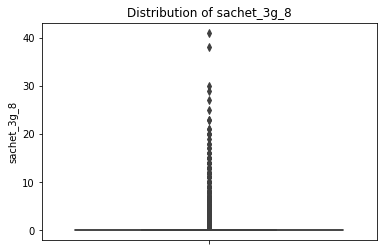

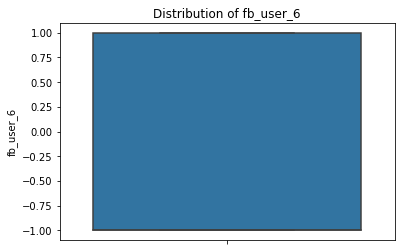

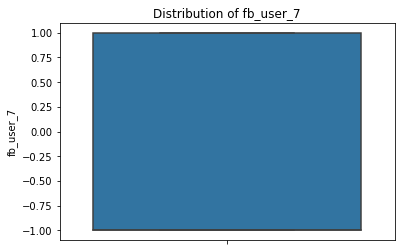

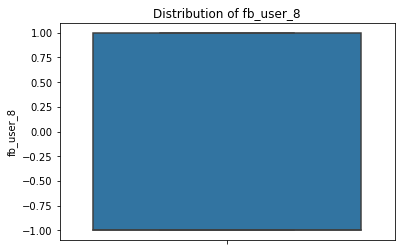

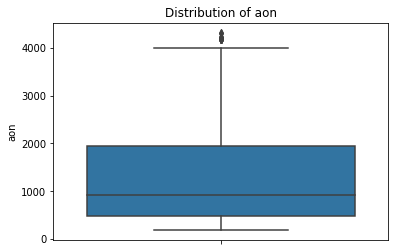

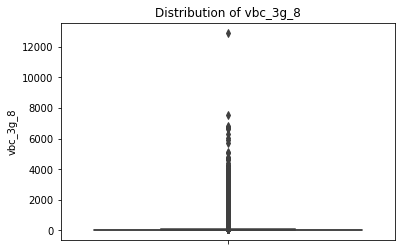

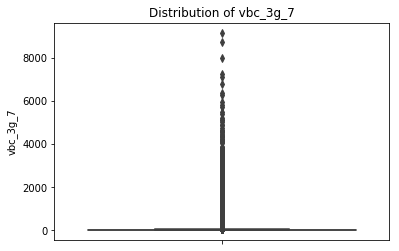

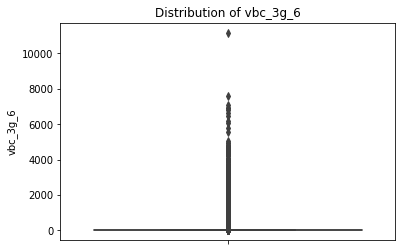

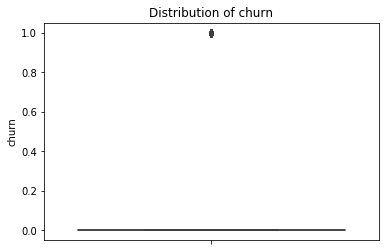

In [26]:
for numeric_val in df._get_numeric_data():
    plot_box(df, numeric_val)

##### No Categorical variable so far, shall do after Deriving new variables

### Deriving New Features

In [27]:
#Taking data in new dataframe for derving data
df_derived = df
# Feature: average revenue per user 
# average revenue per user in a single column and split by average vs first two months average  and 3 months respectively
df_derived['arpu_2_mths'] = (df_derived['arpu_6']+df_derived['arpu_7'])/2
df_derived['arpu_3_mths'] = (df_derived['arpu_6']+df_derived['arpu_7']+df_derived['arpu_8'])/3

In [28]:
# Feature: age on network 
# Convert number of months by 12, that is to years
df_derived['aon_years']=df_derived['aon']/365
df_derived['aon_years'] = df_derived['aon_years'].astype(int)

In [29]:
# Feature:average revenue per user 
# average revenue per user in a single column and split by average vs first two months average and 3 months respectively
df_derived['avg_tot_rech_2_mths'] = (df_derived['total_rech_amt_6']+df_derived['total_rech_amt_7'])/2
df_derived['avg_tot_rech_3_mths'] = (df_derived['total_rech_amt_6']+df_derived['total_rech_amt_7']+df_derived['total_rech_amt_8'])/3

<Figure size 432x288 with 0 Axes>

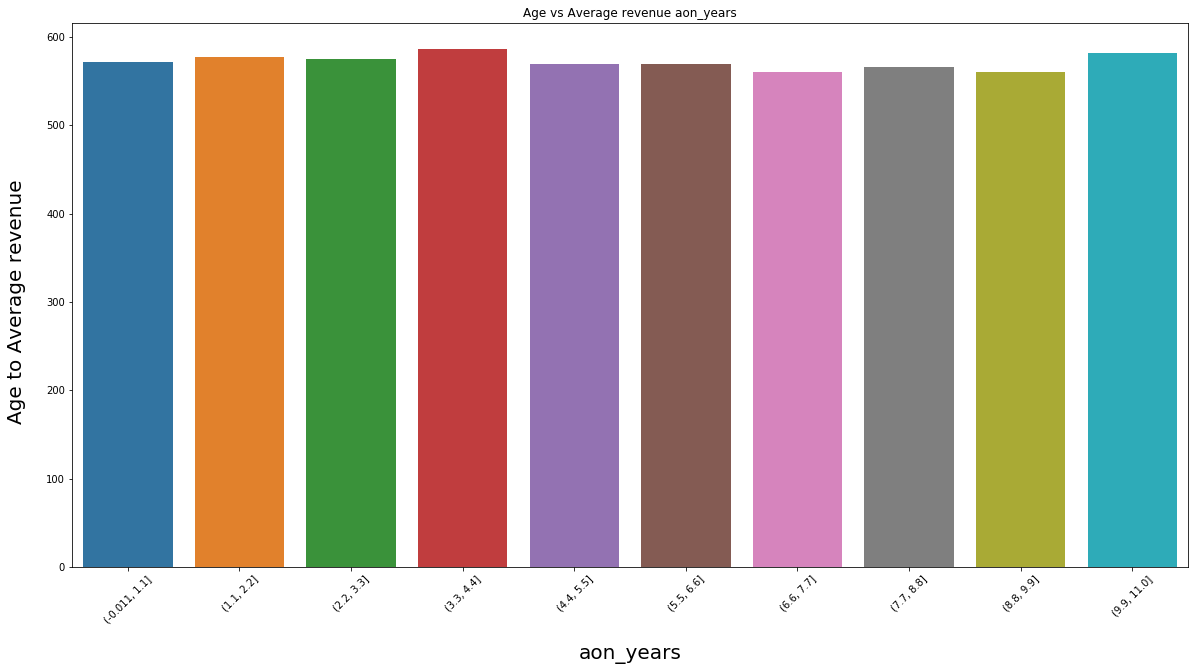

               arpu_2_mths
aon_group                 
(6.6, 7.7]      559.954695
(8.8, 9.9]      559.998945
(7.7, 8.8]      565.525424
(5.5, 6.6]      569.081923
(4.4, 5.5]      569.446762
(-0.011, 1.1]   572.131442
(2.2, 3.3]      574.703067
(1.1, 2.2]      577.689306
(9.9, 11.0]     581.977747
(3.3, 4.4]      586.316275


In [30]:
df_seg_numbins=plot_by_seg_numbins('aon_years','aon_group','arpu_2_mths',10).sort_values(by='arpu_2_mths',ascending=True)
plot_for_seg_univariate('aon_years','arpu_2_mths',df_seg_numbins)
print(df_seg_numbins)

<Figure size 432x288 with 0 Axes>

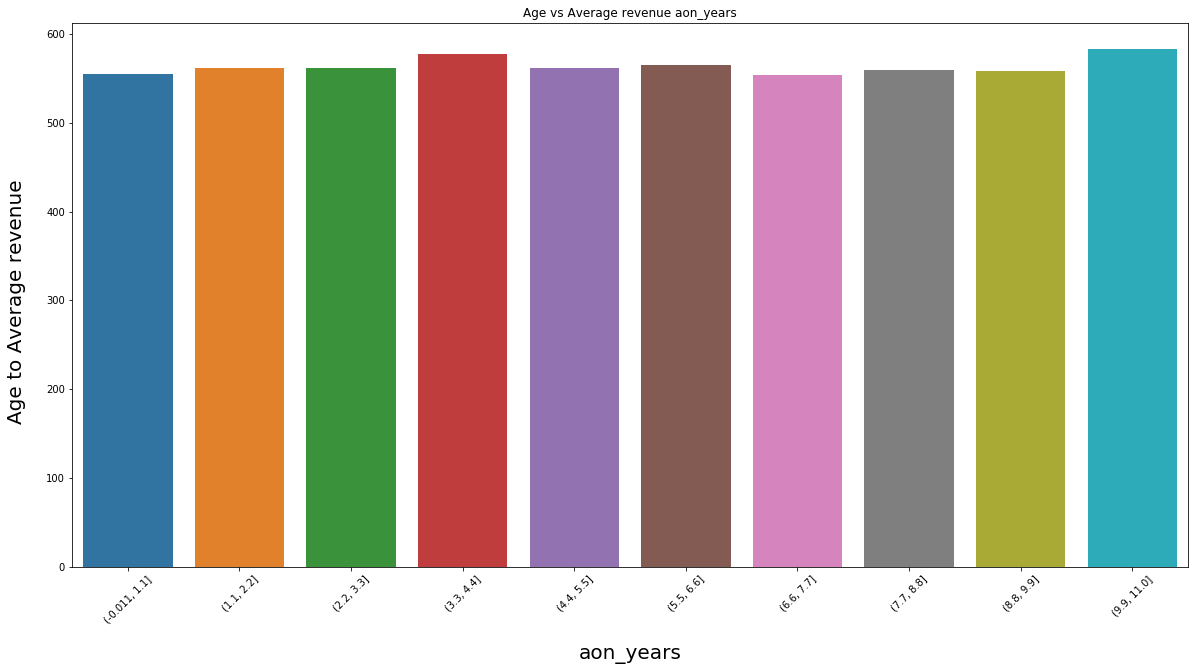

               arpu_3_mths
aon_group                 
(6.6, 7.7]      553.752184
(-0.011, 1.1]   555.428100
(8.8, 9.9]      558.233095
(7.7, 8.8]      559.878892
(1.1, 2.2]      561.342255
(2.2, 3.3]      561.351570
(4.4, 5.5]      562.153366
(5.5, 6.6]      564.744327
(3.3, 4.4]      577.930490
(9.9, 11.0]     582.948571


In [31]:
df_seg_numbins=plot_by_seg_numbins('aon_years','aon_group','arpu_3_mths',10).sort_values(by='arpu_3_mths',ascending=True)
plot_for_seg_univariate('aon_years','arpu_3_mths',df_seg_numbins)
print(df_seg_numbins)

<Figure size 432x288 with 0 Axes>

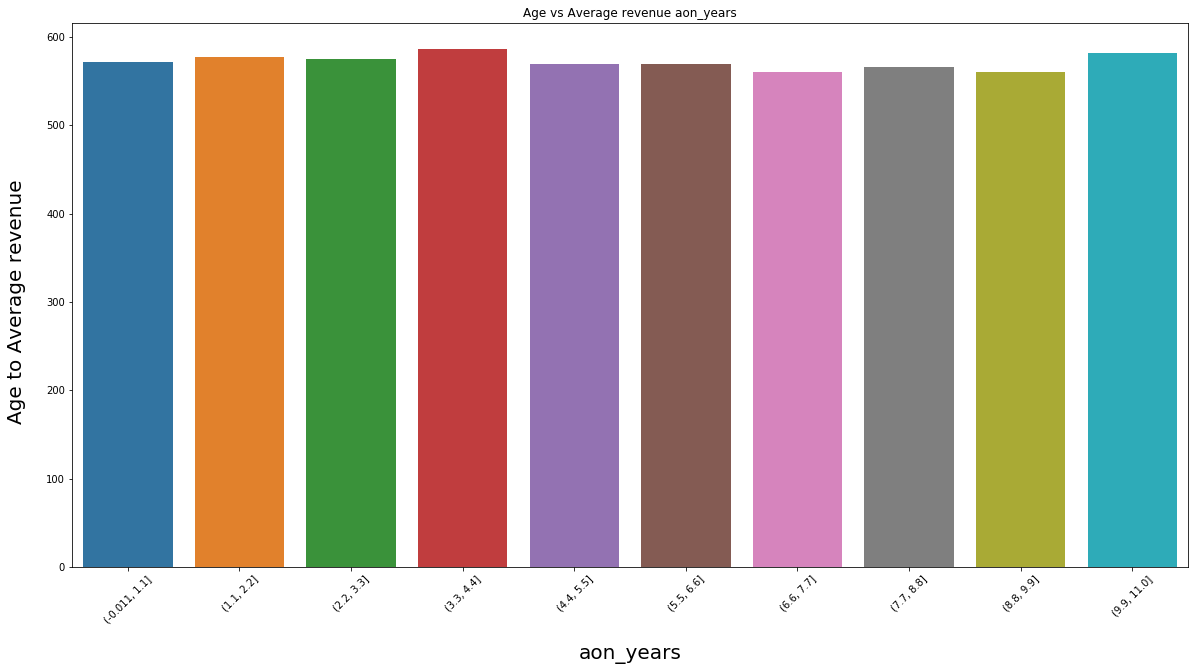

               arpu_2_mths
aon_group                 
(6.6, 7.7]      559.954695
(8.8, 9.9]      559.998945
(7.7, 8.8]      565.525424
(5.5, 6.6]      569.081923
(4.4, 5.5]      569.446762
(-0.011, 1.1]   572.131442
(2.2, 3.3]      574.703067
(1.1, 2.2]      577.689306
(9.9, 11.0]     581.977747
(3.3, 4.4]      586.316275


In [32]:
df_seg_numbins=plot_by_seg_numbins('aon_years','aon_group','arpu_2_mths',10).sort_values(by='arpu_2_mths',ascending=True)
plot_for_seg_univariate('aon_years','arpu_2_mths',df_seg_numbins)
print(df_seg_numbins)

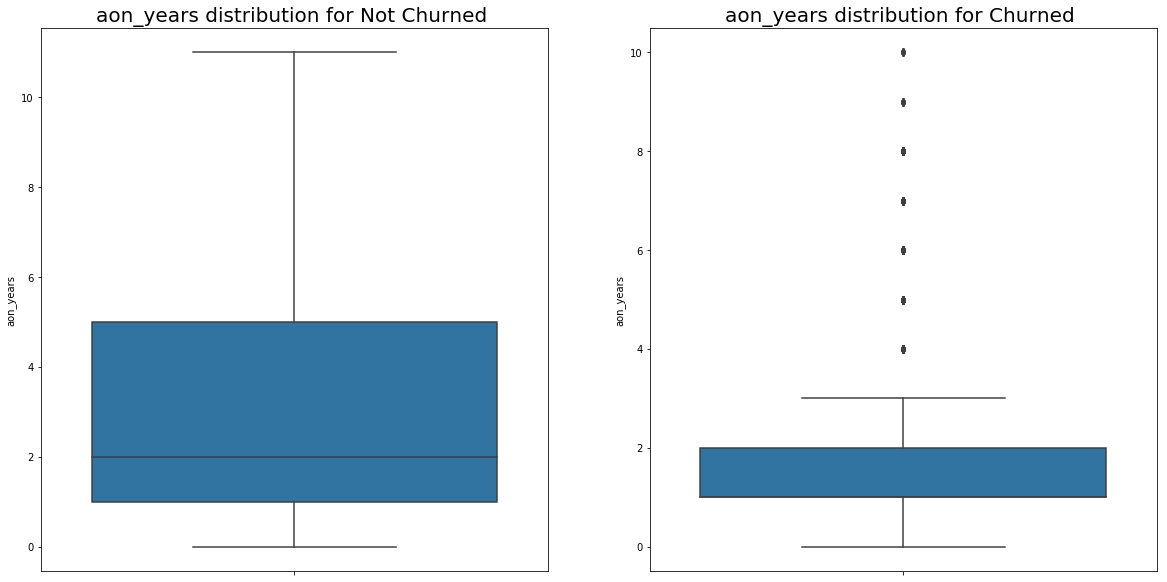

In [33]:
df_aon = df[['churn','aon_years']]
plot_continuous_var_boxPlot(df_aon,'aon_years')

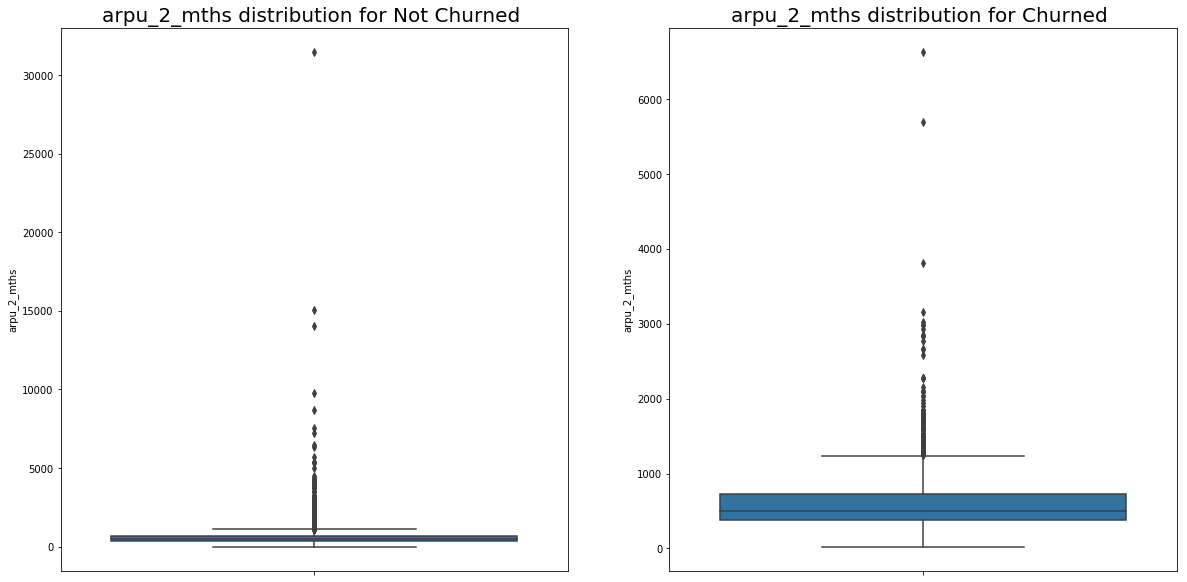

In [34]:
df_arpu = df[['churn','arpu_2_mths']]
plot_continuous_var_boxPlot(df_arpu,'arpu_2_mths')

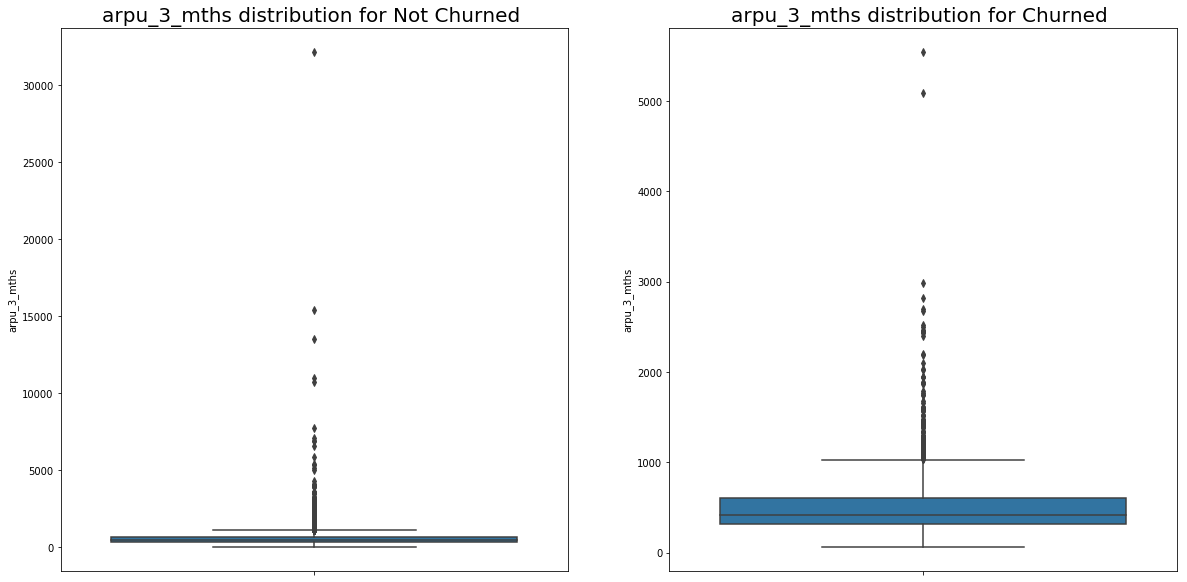

In [35]:
df_arpu_3 = df[['churn','arpu_3_mths']]
plot_continuous_var_boxPlot(df_arpu_3,'arpu_3_mths')

In [36]:
df_derived['aon_years'].value_counts()

1     7702
0     4859
2     4681
3     3103
6     2109
4     1997
7     1869
8     1565
5     1282
9      582
10     566
11      28
Name: aon_years, dtype: int64

In [37]:
df_derived['churn'].value_counts()

0    28468
1     1875
Name: churn, dtype: int64

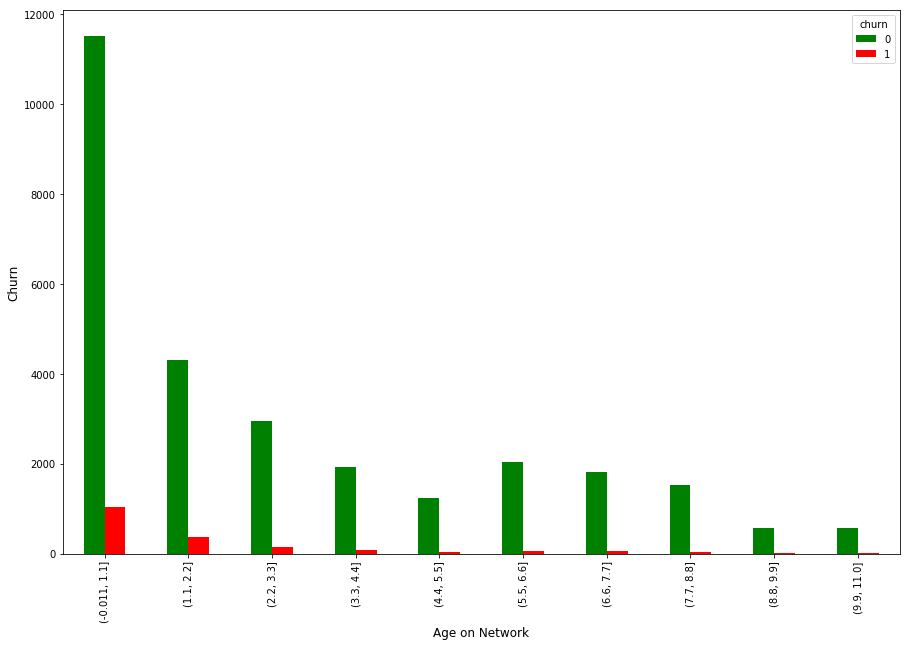

churn              0     1
aon_group                 
(-0.011, 1.1]  11520  1041
(1.1, 2.2]      4306   375
(2.2, 3.3]      2949   154
(3.3, 4.4]      1918    79
(4.4, 5.5]      1241    41
(5.5, 6.6]      2043    66
(6.6, 7.7]      1813    56
(7.7, 8.8]      1527    38
(8.8, 9.9]       569    13
(9.9, 11.0]      582    12


In [38]:
df_Age_of_Network=pd.pivot_table(df_derived, index='aon_group', columns=['churn'],values='aon', aggfunc='count')
plot_by_grouped_barcharts(df_Age_of_Network,'Age on Network')
print(df_Age_of_Network)

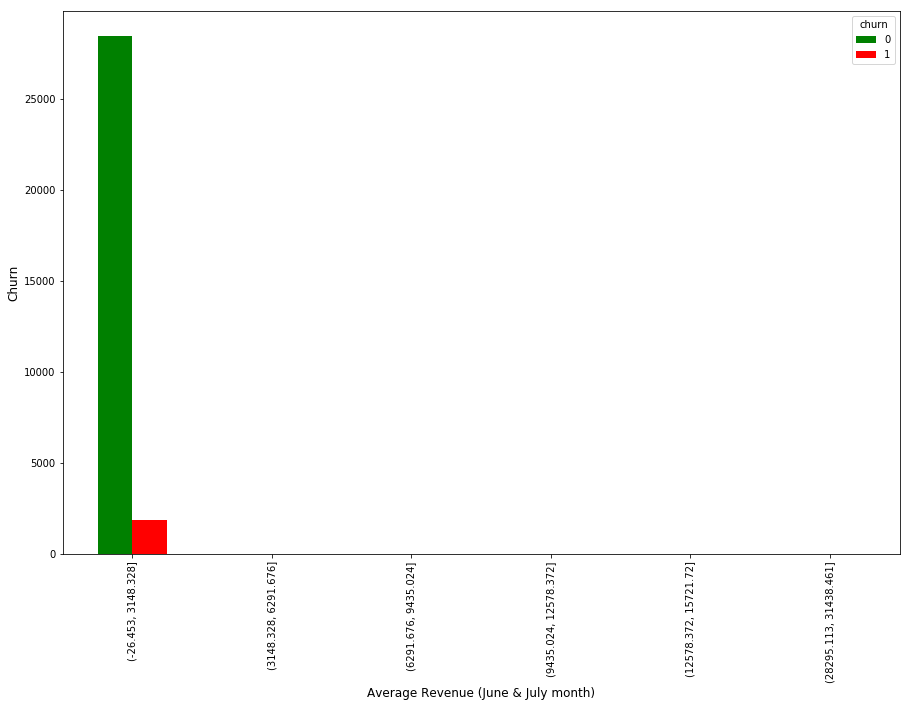

churn                       0     1
arpu_group_2_mths                  
(-26.453, 3148.328]     28435  1871
(3148.328, 6291.676]       24     3
(6291.676, 9435.024]        5     1
(9435.024, 12578.372]       1     0
(12578.372, 15721.72]       2     0
(28295.113, 31438.461]      1     0


In [39]:
df=create_bin('arpu_2_mths','arpu_group_2_mths',10)
df_Avg_Rev=pd.pivot_table(df, index='arpu_group_2_mths', columns=['churn'],values='arpu_2_mths', aggfunc = 'count',fill_value=0)
plot_by_grouped_barcharts(df_Avg_Rev,'Average Revenue (June & July month)')
print(df_Avg_Rev)

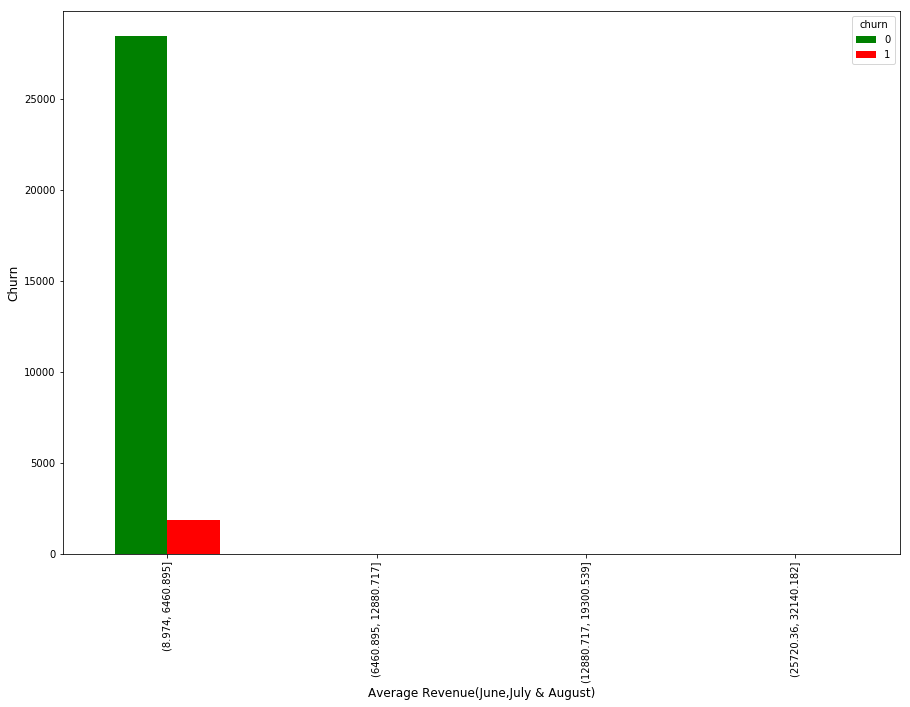

churn                       0     1
arpu_group_3_mths                  
(8.974, 6460.895]       28458  1875
(6460.895, 12880.717]       7     0
(12880.717, 19300.539]      2     0
(25720.36, 32140.182]       1     0


In [40]:
df=create_bin('arpu_3_mths','arpu_group_3_mths',5)
df_Avg_Rev=pd.pivot_table(df, index='arpu_group_3_mths', columns=['churn'],values='arpu_3_mths', aggfunc = 'count',fill_value=0)
plot_by_grouped_barcharts(df_Avg_Rev,'Average Revenue(June,July & August)')
print(df_Avg_Rev)

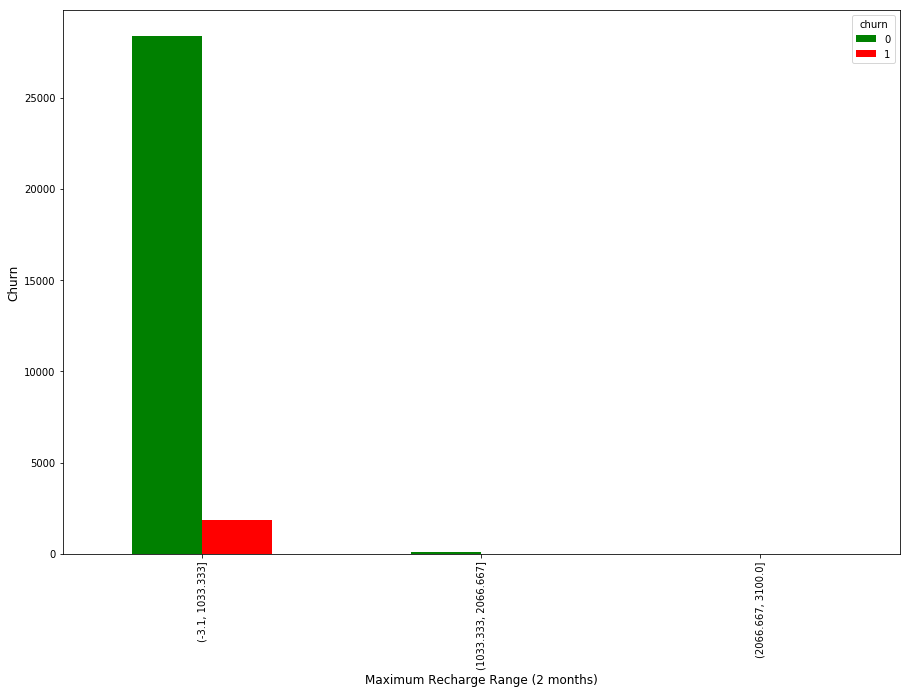

churn                          0     1
max_rech_amt_group_2_mths             
(-3.1, 1033.333]           28379  1861
(1033.333, 2066.667]          83    12
(2066.667, 3100.0]             6     2


In [41]:
df_derived['avg_max_rech_amt']=(df_derived['max_rech_amt_6']+df_derived['max_rech_amt_7'])/2
df=create_bin('avg_max_rech_amt','max_rech_amt_group_2_mths',3)
df_max_rech=pd.pivot_table(df_derived, index='max_rech_amt_group_2_mths', columns=['churn'],values='avg_max_rech_amt', aggfunc = 'count',fill_value=0)
plot_by_grouped_barcharts(df_max_rech,'Maximum Recharge Range (2 months)')
print(df_max_rech)

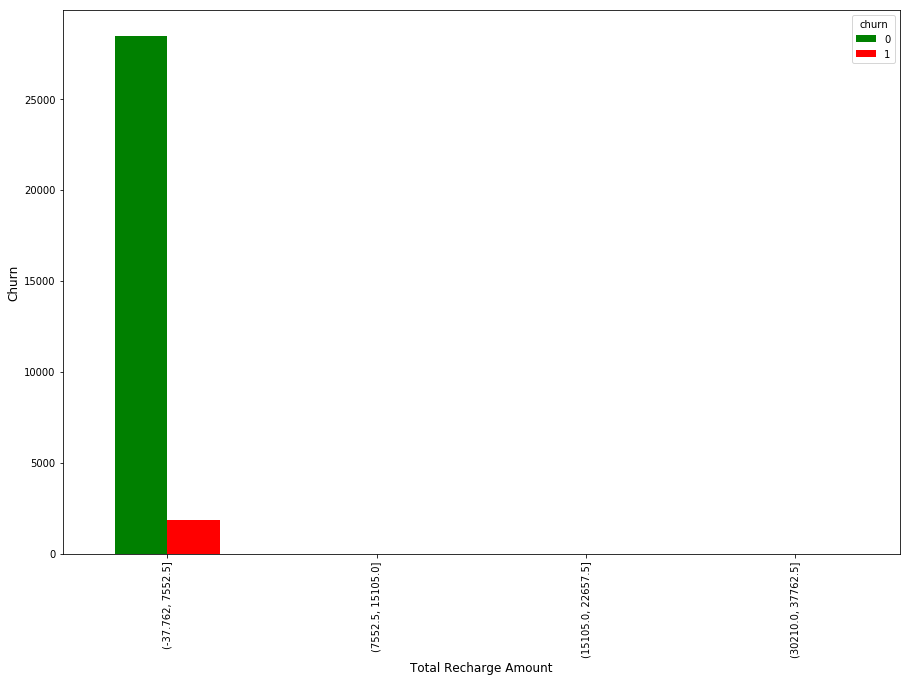

churn                            0     1
total_rech_amt_group_2_mths             
(-37.762, 7552.5]            28461  1873
(7552.5, 15105.0]                3     2
(15105.0, 22657.5]               3     0
(30210.0, 37762.5]               1     0


In [42]:
df['avg_total_rech_amt']=(df['total_rech_amt_6']+df['total_rech_amt_7'])/2
df=create_bin('avg_total_rech_amt','total_rech_amt_group_2_mths',5)
df_total_rech=pd.pivot_table(df, index='total_rech_amt_group_2_mths', columns=['churn'],values='avg_total_rech_amt', aggfunc = 'count',fill_value=0)
plot_by_grouped_barcharts(df_total_rech,'Total Recharge Amount')
print(df_total_rech)

### Bivariate Analysis

In [43]:
# Let's see the correlation matrix 
corr = df._get_numeric_data().corr()
print(corr)

                     mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  \
mobile_number             1.000000  0.021140  0.010232  0.016600    -0.006551   
arpu_6                    0.021140  1.000000  0.698460  0.642062     0.311363   
arpu_7                    0.010232  0.698460  1.000000  0.763052     0.172110   
arpu_8                    0.016600  0.642062  0.763052  1.000000     0.120472   
onnet_mou_6              -0.006551  0.311363  0.172110  0.120472     1.000000   
onnet_mou_7              -0.012029  0.180855  0.281136  0.195870     0.745956   
onnet_mou_8              -0.009898  0.155926  0.229957  0.312692     0.623074   
offnet_mou_6              0.007005  0.488321  0.320318  0.253825     0.029843   
offnet_mou_7             -0.005452  0.310141  0.455112  0.337523    -0.022719   
offnet_mou_8              0.003602  0.267157  0.358538  0.491267    -0.017666   
roam_ic_mou_6             0.009352  0.111290  0.085089  0.082153     0.011005   
roam_ic_mou_7            -0.

No handles with labels found to put in legend.


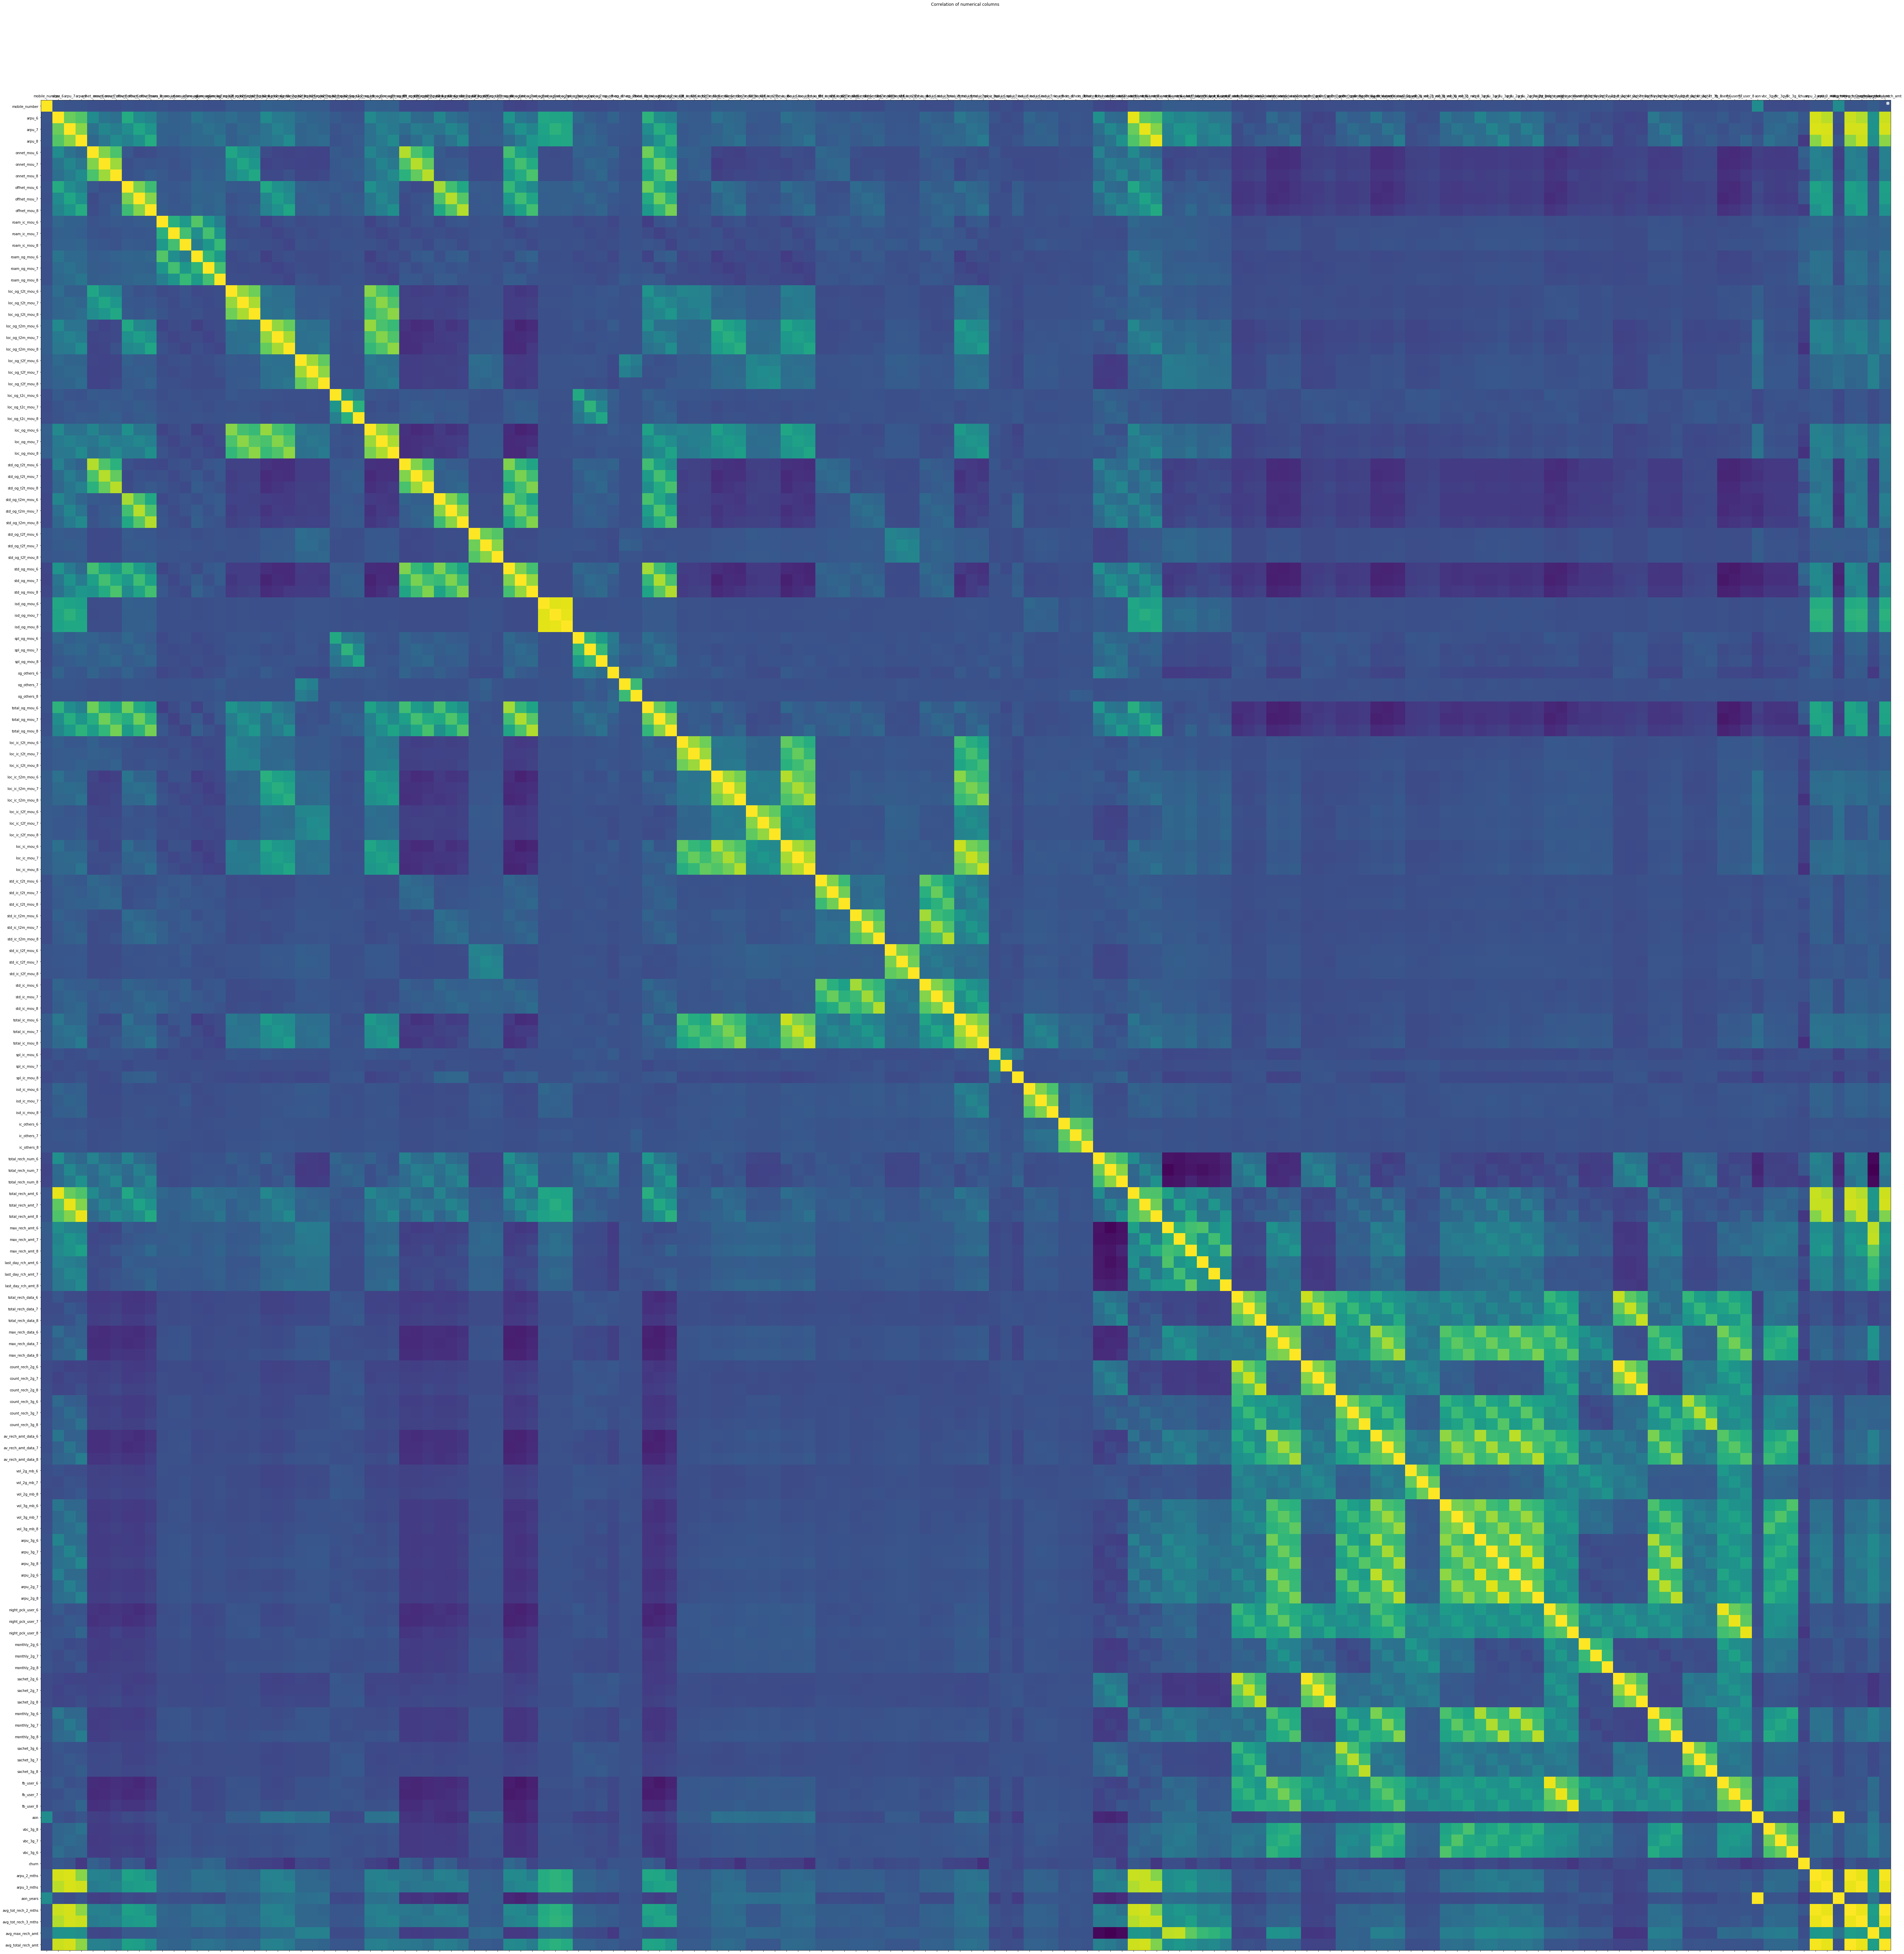

In [44]:
# Find index of feature columns with correlation greater than 0.95

fig, ax = plt.subplots(figsize=(120, 100))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
ax.legend()
plt.title('Correlation of numerical columns ')
plt.show()

 Due to High dimensionality , skipping batch wise analysis for now.Bivariate and Segmented Univariate Analysis to be done by considering the columns in batches. We will try to do PCA now as the number of feature are too high.

### PCA-Principal Component Analysis
##### Data Preparation for PCA
We need to Handling Categorical variables before we start with PCA ( Dimentionality Reduction )

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

In [46]:
df_PCA=df_derived._get_numeric_data()

In [47]:
X = df_PCA.drop(['churn','mobile_number'],axis=1)
y = df_PCA['churn']
y.head()

0     1
7     1
8     0
13    0
16    0
Name: churn, dtype: int32

In [48]:
y.shape

(30343,)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [50]:
# X_scaler = StandardScaler().fit(X_train,y_train)

In [51]:
Scaled_Xtrain = StandardScaler().fit_transform(X_train,y_train)

In [52]:
# Representing LinearRegression as le_reg(Creating LinearRegression Object)
le_reg = LinearRegression()

# Fit the model using le_reg.fit()
le_reg.fit(Scaled_Xtrain, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [53]:
# X_test_scaler = StandardScaler().fit(X_test,y_test)
# Scaled_Xtest=X_test_scaler.transform(X_test,y_test)
Scaled_Xtest= StandardScaler().fit_transform(X_test,y_test)

In [54]:
y_pred = le_reg.predict(Scaled_Xtest)

In [55]:
y_test.unique()

array([0, 1], dtype=int64)

In [56]:
mean_square_error = mean_squared_error(y_test, y_pred)
print(mean_square_error)

2.2384662568184844e+19


In [57]:
Scaled_Xtrain = StandardScaler().fit_transform(X_train,y_train)

In [58]:
X.shape

(30343, 158)

In [59]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

-3.8579213716032225e+20


In [60]:
Scaled_Xtrain.shape

(21240, 158)

In [61]:
# Apply PCA function
pca = PCA(svd_solver='randomized', random_state=100)
pca.fit(Scaled_Xtrain)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
  svd_solver='randomized', tol=0.0, whiten=False)

In [62]:
# let's see an overview of components formed. ( PCA created components )
pca.components_

array([[ 4.99224844e-02,  5.18279597e-02,  5.61621629e-02, ...,
         5.60003180e-02,  9.24211761e-02,  5.23970022e-02],
       [ 1.93078044e-01,  1.99116108e-01,  1.93567726e-01, ...,
         2.14070112e-01,  9.31160217e-02,  2.10639343e-01],
       [ 6.28130932e-02,  8.07038384e-02,  6.54251232e-02, ...,
         7.68427537e-02, -3.65319431e-02,  7.66448368e-02],
       ...,
       [-0.00000000e+00, -5.32473455e-17, -1.05327009e-02, ...,
        -3.30771627e-02, -7.81504185e-02,  9.58218983e-03],
       [ 0.00000000e+00,  1.64669796e-18,  9.97592699e-08, ...,
        -2.34165170e-07,  1.20439392e-06,  7.07106998e-01],
       [-4.50594819e-01, -4.93845365e-01, -1.40923237e-01, ...,
        -9.77950360e-17,  2.97288236e-16, -4.92661467e-16]])

In [63]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

PC1       PC2      Feature
0  0.049922  0.193078       arpu_6
1  0.051828  0.199116       arpu_7
2  0.056162  0.193568       arpu_8
3 -0.052616  0.086381  onnet_mou_6
4 -0.054195  0.094546  onnet_mou_7

Let's see 'explained_variance_ratio_' - The fraction of variance explained by a principal component is the ratio between the variance of that principal component and the total variance. For several principal components, add up their variances and divide by the total variance


In [64]:
pca.explained_variance_ratio_

array([1.22470575e-01, 1.01083017e-01, 7.02351235e-02, 5.40968243e-02,
       3.93507011e-02, 3.67707209e-02, 2.90319380e-02, 2.66052502e-02,
       2.40184201e-02, 2.18572461e-02, 2.04743453e-02, 1.83512329e-02,
       1.79796701e-02, 1.77899685e-02, 1.69322564e-02, 1.60681100e-02,
       1.59088102e-02, 1.45377560e-02, 1.28800709e-02, 1.24896318e-02,
       1.17741105e-02, 1.11772556e-02, 1.09454550e-02, 1.05637290e-02,
       9.95339735e-03, 9.69613613e-03, 9.35548647e-03, 8.60979548e-03,
       8.35298768e-03, 8.02192427e-03, 7.57413973e-03, 7.37492760e-03,
       6.98396608e-03, 6.85904594e-03, 6.10444461e-03, 5.99990787e-03,
       5.90446510e-03, 5.78936901e-03, 5.74111403e-03, 5.67199995e-03,
       5.22127679e-03, 5.08866954e-03, 5.04407799e-03, 4.83336309e-03,
       4.78539069e-03, 4.68293411e-03, 4.58451221e-03, 4.52422172e-03,
       4.31646605e-03, 4.06289798e-03, 3.84226135e-03, 3.74897762e-03,
       3.63560635e-03, 3.51410931e-03, 3.47777623e-03, 3.26145878e-03,
      

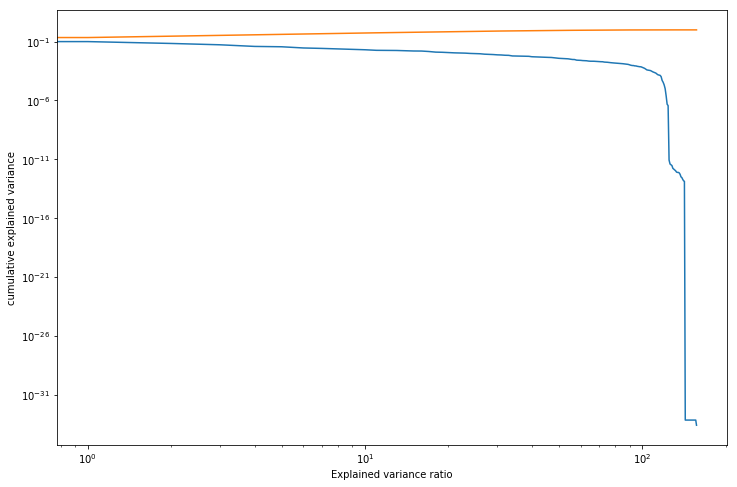

In [65]:
#Plotting the cumulative vs against the explained variance ration
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.yscale('log')
plt.xscale('log')
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Explained variance ratio')
plt.ylabel('cumulative explained variance')
plt.show()

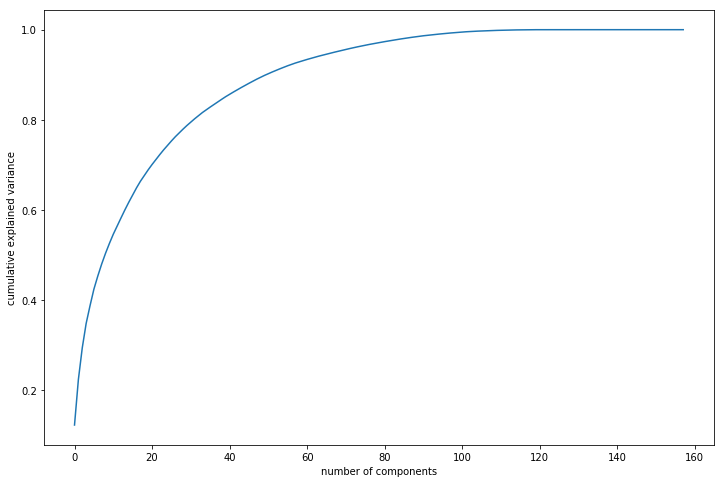

In [66]:
#Plot the cumulative variance Vs the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [67]:
from sklearn.decomposition import IncrementalPCA
final_pca = IncrementalPCA(n_components=81)

In [68]:
train_pca = final_pca.fit_transform(Scaled_Xtrain)
train_pca.shape

(21240, 81)

In [69]:
#Correlation matrix for the principal PCA
corrmat = np.corrcoef(train_pca.transpose())

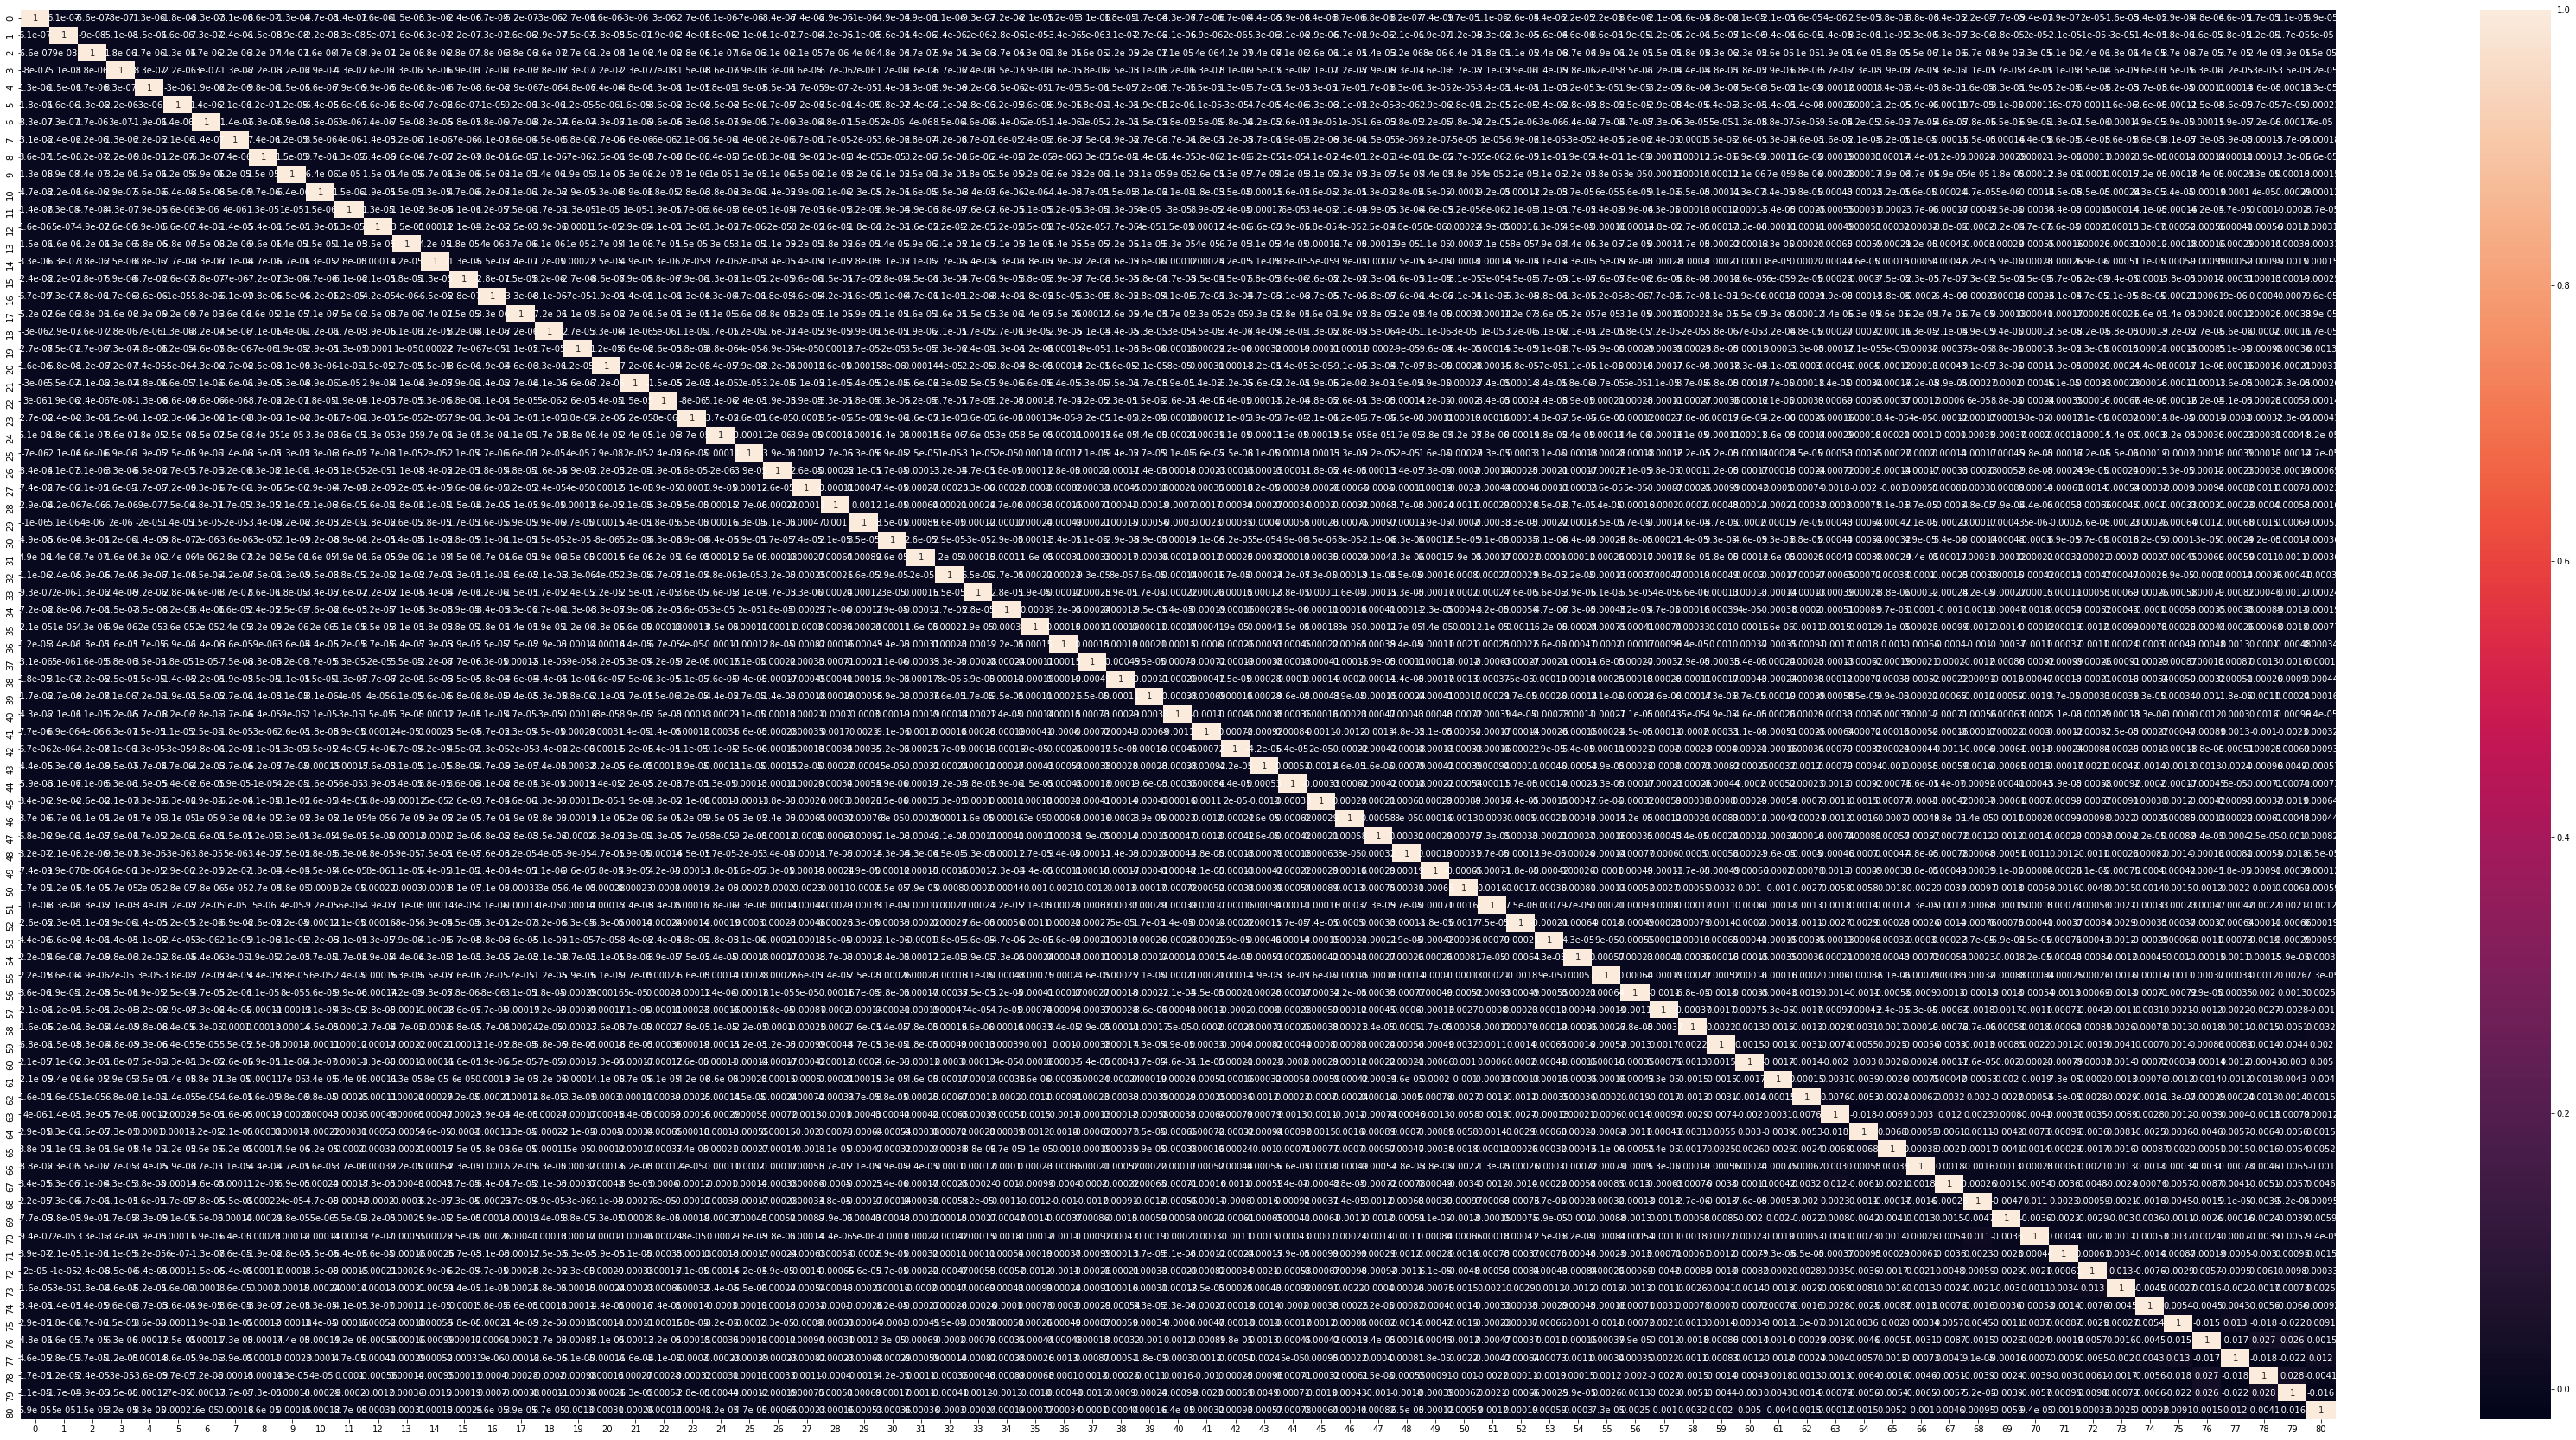

In [70]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (60,30))
sns.heatmap(corrmat,annot = True)

In [71]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.02818802217319604 , min corr:  -0.022030345487052003


In [72]:
# Apply selected components to test data 
test_pca = final_pca.transform(Scaled_Xtest)
test_pca.shape

(9103, 81)

In [73]:
#let's train the model
learner_pca = LinearRegression()
model_pca = learner_pca.fit(train_pca,y_train)

In [74]:
y_predicted_pca = model_pca.predict(test_pca)

In [75]:
# Find R2 ( mean square error )
mean_square_error = mean_squared_error(y_test, y_predicted_pca)
mean_square_error

0.05136799050432146

In [76]:
# Let's call PCA .. considering components = 85 as we see in the graph we are seeing the variance in 80-90 .. 
pca_2 = PCA(n_components=81,random_state=100)

In [77]:
# let's apply components to train data (Scaled_Xtrain)
train_pca = pca_2.fit_transform(Scaled_Xtrain)
train_pca.shape

(21240, 81)

In [78]:
pca_2 

PCA(copy=True, iterated_power='auto', n_components=81, random_state=100,
  svd_solver='auto', tol=0.0, whiten=False)

In [79]:
# let's apply components to test data (Scaled_Xtest)
test_pca = pca_2.fit_transform(Scaled_Xtest)
test_pca.shape

(9103, 81)

In [80]:
train_pca

array([[-0.47672262,  3.76149804, -1.50794305, ...,  1.07150396,
        -0.41735135,  0.6682162 ],
       [ 1.09742275, -4.35541496,  0.18101227, ...,  0.28302219,
        -0.1014598 , -0.31778343],
       [-3.23770309, -0.64965875,  0.49497138, ..., -0.04155561,
        -0.43516845, -0.35711024],
       ...,
       [-2.39279595,  0.47325622, -5.33245239, ...,  0.07826359,
         0.05017513,  0.23212364],
       [ 0.70462845, -1.39296769,  2.76097253, ...,  0.75715579,
        -0.81337631, -0.800254  ],
       [ 0.04833593,  0.41688754, -2.21131973, ..., -0.03638724,
        -0.0463524 , -0.38253885]])

In [81]:
# After reducing the dimentionality let's train the model using mulitple regression alogrithims. 

#Let's start with LinearRegression.
learner_pca = LinearRegression()
model_pca = learner_pca.fit(train_pca,y_train)

In [82]:
y_predicted_pca = model_pca.predict(test_pca)

In [83]:
y_predicted_pca

array([0.08099082, 0.16507849, 0.05637444, ..., 0.19341618, 0.02102292,
       0.22129314])

In [84]:
mean_square_error = mean_squared_error(y_test, y_predicted_pca)
mean_square_error

0.05891320029461875

In [85]:
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_predicted_pca)))

RMSE : 0.24272041589989654


In [86]:
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'PC4':pca.components_[3],'Feature':colnames})
pcs_df

PC1       PC2       PC3       PC4              Feature
0    0.049922  0.193078  0.062813 -0.004917               arpu_6
1    0.051828  0.199116  0.080704 -0.005205               arpu_7
2    0.056162  0.193568  0.065425  0.001875               arpu_8
3   -0.052616  0.086381  0.073664  0.046504          onnet_mou_6
4   -0.054195  0.094546  0.085593  0.051772          onnet_mou_7
5   -0.046119  0.095115  0.078730  0.054415          onnet_mou_8
6   -0.036540  0.137766  0.031749  0.038196         offnet_mou_6
7   -0.039102  0.143048  0.048222  0.039682         offnet_mou_7
8   -0.027931  0.139323  0.036894  0.043709         offnet_mou_8
9    0.003445  0.021989  0.015287 -0.024613        roam_ic_mou_6
10   0.006422  0.017173  0.013241 -0.030517        roam_ic_mou_7
11   0.007096  0.020870  0.012439 -0.021912        roam_ic_mou_8
12  -0.004755  0.031680  0.035443 -0.027789        roam_og_mou_6
13  -0.000288  0.031403  0.035502 -0.036234        roam_og_mou_7
14   0.001007  0.032708  0.034072 -0.030776        roam_og_mou_8
15   0.004052  0.065606 -0.081404  0.064568     loc_og_t2t_mou_6
16   0.002488  0.071498 -0.074541  0.070329     loc_og_t2t_mou_7
17   0.005290  0.072618 -0.074204  0.068519     loc_og_t2t_mou_8
18   0.013942  0.101562 -0.142158  0.046133     loc_og_t2m_mou_6
19   0.013056  0.107996 -0.140821  0.047659     loc_og_t2m_mou_7
20   0.018009  0.106806 -0.137835  0.047415     loc_og_t2m_mou_8
21   0.019800  0.046345 -0.086260 -0.027193     loc_og_t2f_mou_6
22   0.020097  0.046788 -0.085905 -0.028521     loc_og_t2f_mou_7
23   0.020747  0.046650 -0.084569 -0.027962     loc_og_t2f_mou_8
24   0.000411  0.010656  0.012802  0.036355     loc_og_t2c_mou_6
25  -0.003402  0.008257  0.023343  0.032767     loc_og_t2c_mou_7
26  -0.002609  0.010361  0.020168  0.033859     loc_og_t2c_mou_8
27   0.012683  0.109371 -0.147786  0.068693         loc_og_mou_6
28   0.011084  0.118443 -0.143497  0.075130         loc_og_mou_7
29   0.016006  0.117506 -0.140288  0.073089         loc_og_mou_8
..        ...       ...       ...       ...                  ...
128  0.171866  0.008856  0.041041 -0.066379            arpu_2g_8
129  0.149893 -0.046549  0.011035  0.092483     night_pck_user_6
130  0.150095 -0.046006  0.017719  0.098975     night_pck_user_7
131  0.141499 -0.032595  0.020110  0.103433     night_pck_user_8
132  0.053090 -0.022238 -0.026761  0.024069         monthly_2g_6
133  0.052297 -0.023839 -0.025176  0.026840         monthly_2g_7
134  0.051589 -0.019201 -0.026658  0.032205         monthly_2g_8
135  0.048852 -0.056476  0.043918  0.231974          sachet_2g_6
136  0.047443 -0.054837  0.048531  0.240638          sachet_2g_7
137  0.045232 -0.048892  0.047876  0.232941          sachet_2g_8
138  0.147061  0.001285  0.027791 -0.088610         monthly_3g_6
139  0.149884  0.004525  0.030854 -0.089538         monthly_3g_7
140  0.149843  0.009613  0.025076 -0.083823         monthly_3g_8
141  0.068751 -0.026382  0.041932  0.091198          sachet_3g_6
142  0.069230 -0.024167  0.051678  0.098815          sachet_3g_7
143  0.066324 -0.020649  0.050994  0.100481          sachet_3g_8
144  0.156817 -0.048912  0.004787  0.081059            fb_user_6
145  0.158265 -0.049153  0.010839  0.086951            fb_user_7
146  0.153882 -0.037765  0.011916  0.091644            fb_user_8
147  0.015451  0.015831 -0.104465 -0.040671                  aon
148  0.138104  0.001341  0.011980 -0.041594             vbc_3g_8
149  0.138524 -0.002845  0.015539 -0.041686             vbc_3g_7
150  0.135009 -0.001225  0.012494 -0.044593             vbc_3g_6
151  0.054847  0.211376  0.077736 -0.005458          arpu_2_mths
152  0.058194  0.215510  0.077049 -0.002932          arpu_3_mths
153  0.014925  0.015968 -0.103606 -0.040548            aon_years
154  0.052397  0.210639  0.076645 -0.010597  avg_tot_rech_2_mths
155  0.056000  0.214070  0.076843 -0.006239  avg_tot_rech_3_mths
156  0.092421  0.093116 -0.036532 -0.132333     avg_max_rech_amt
157  0.052397  0.210639  0.076645 -0.010597  

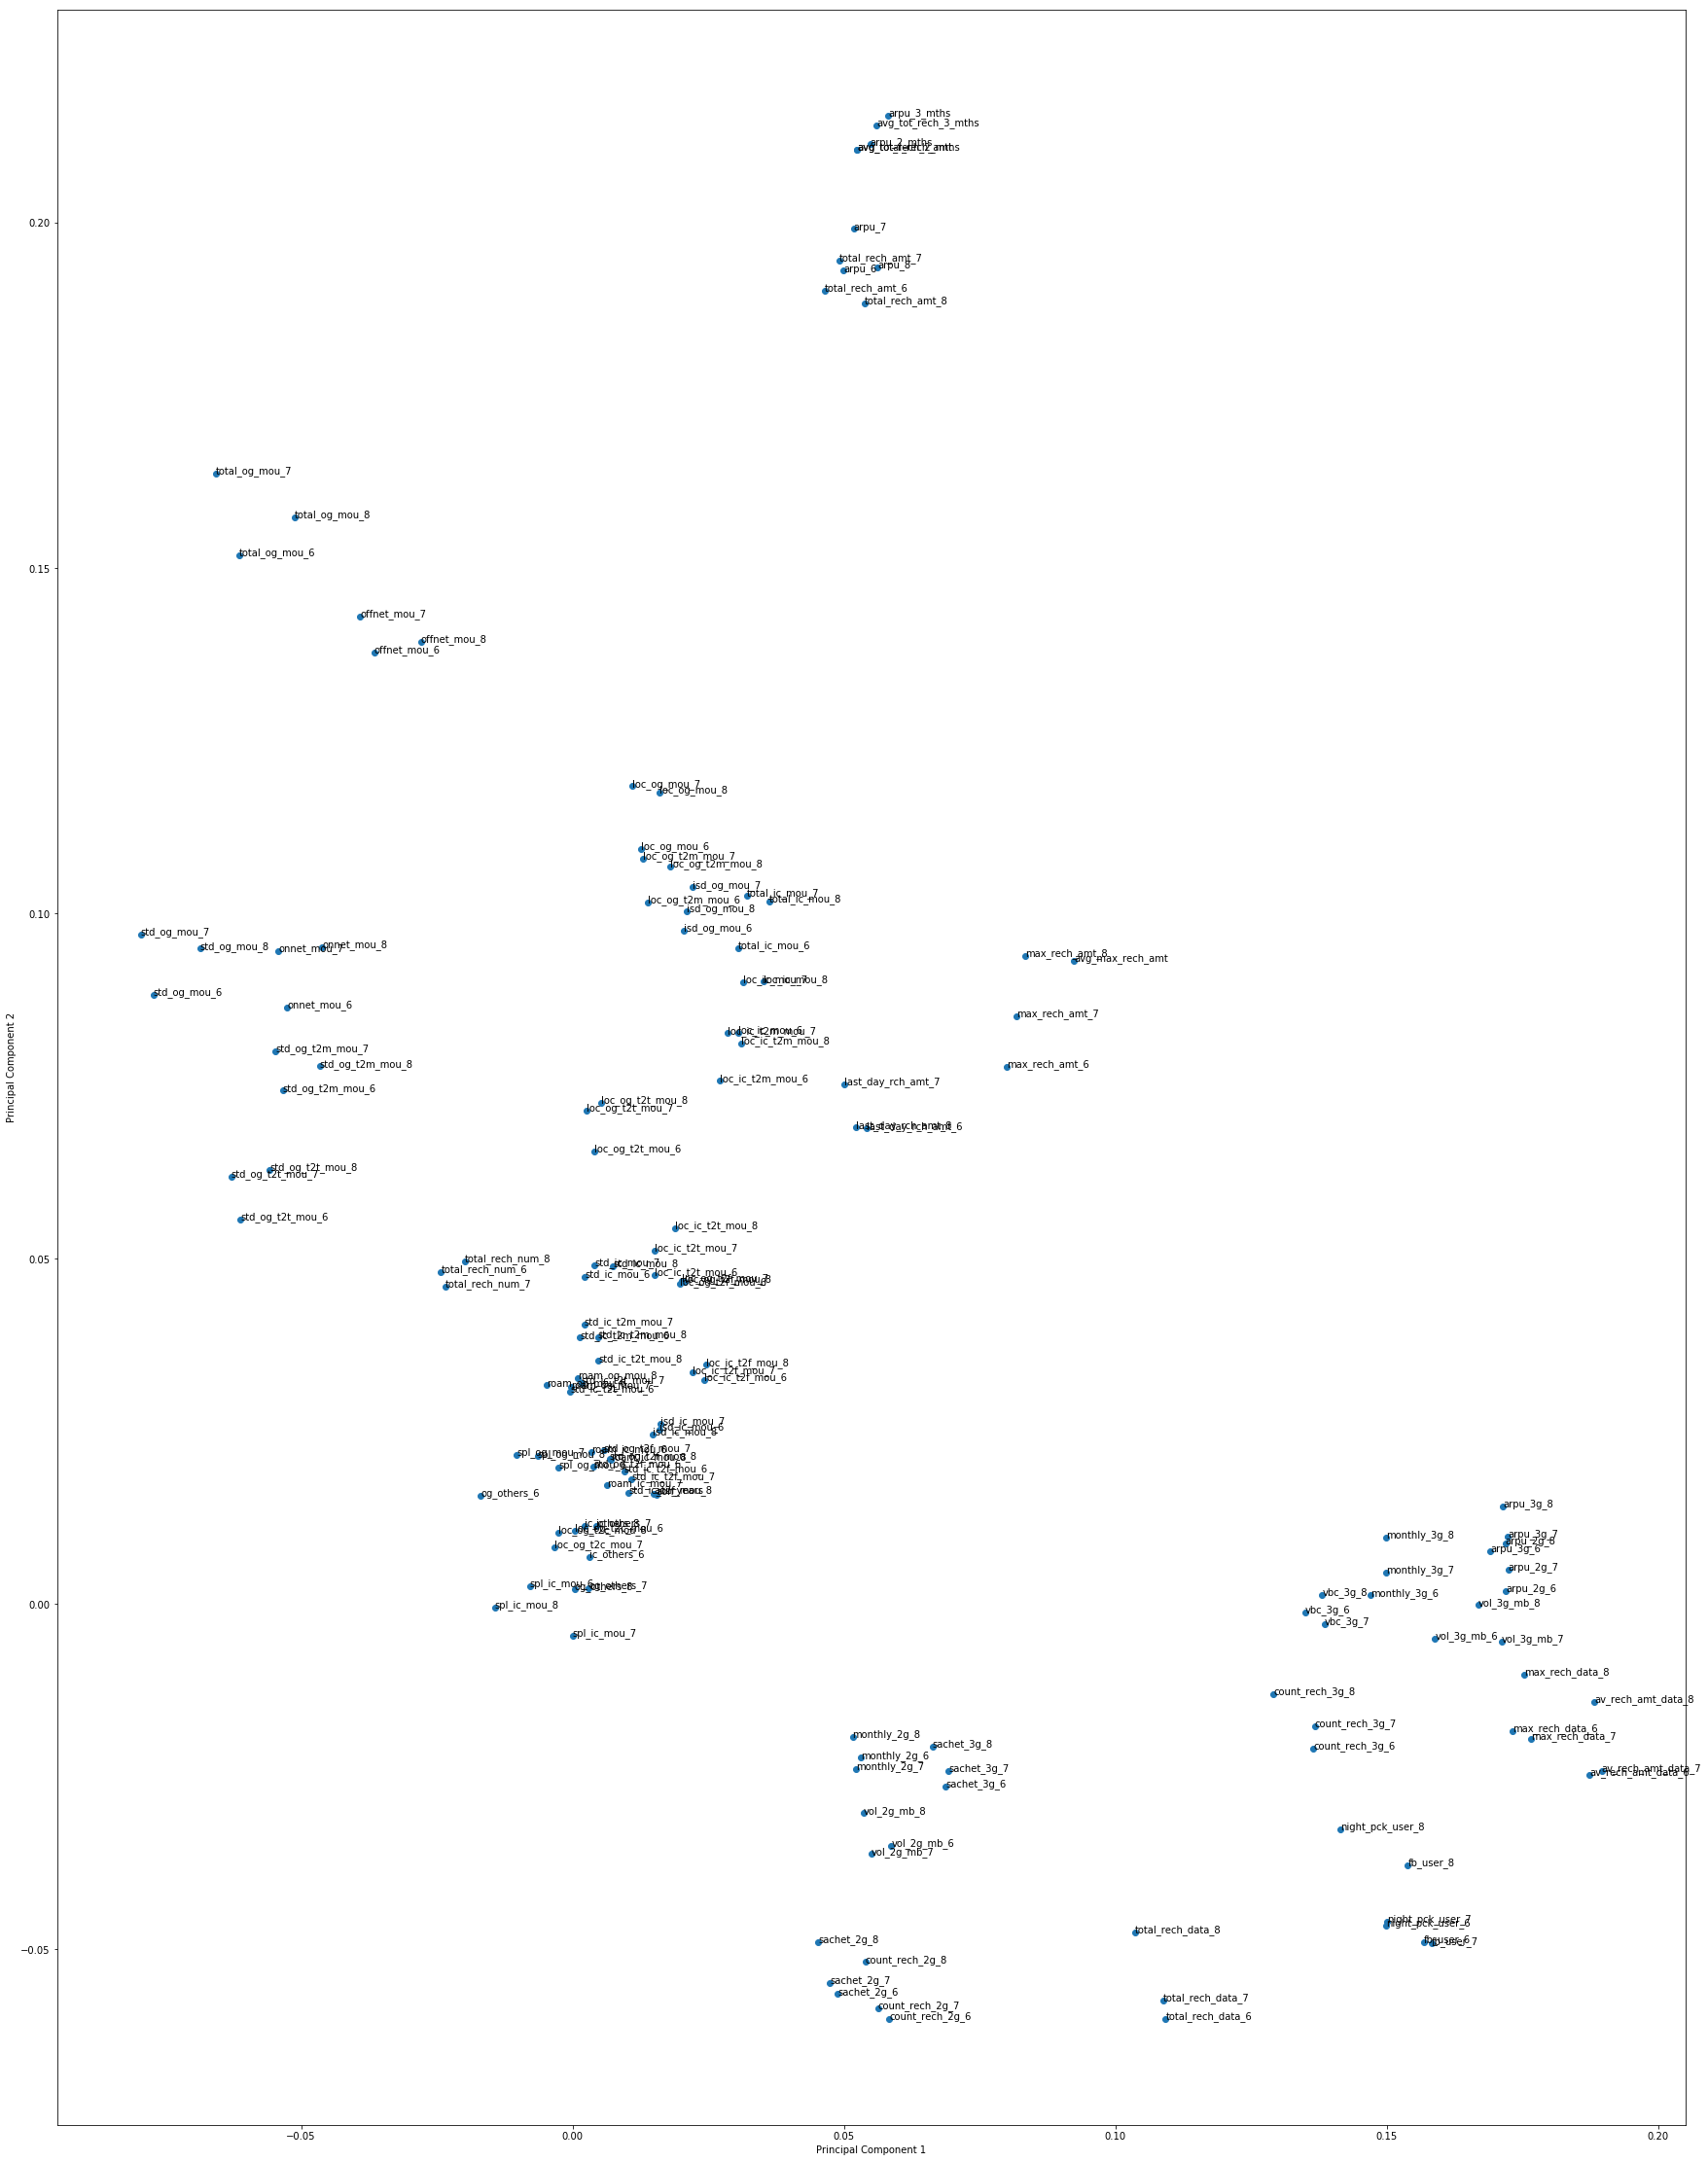

In [87]:
%matplotlib inline
fig = plt.figure(figsize = (30,40))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
#plt.tight_layout()
plt.show()

In [88]:
train_pca.shape

(21240, 81)

In [89]:
#let's apply logisregression model
LogSk_learner_pca2 = LogisticRegression(class_weight='balanced')
model_pca2 = LogSk_learner_pca2.fit(train_pca,y_train)

In [90]:
# Make test data predictions
pred_probs_test= model_pca2.predict_proba(test_pca)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.65'

In [91]:
# Convert y_pred to a df from array
y_pred_df = pd.DataFrame(pred_probs_test)

In [92]:
# Convert column to df
y_pred_1 = y_pred_df.iloc[:,[0]]

In [93]:
# Converting y_test to df
y_test_df = pd.DataFrame(y_test)

In [94]:
# Remove index for both df to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True,inplace=True)

In [95]:
y_pred_1.head()

0
0  0.742138
1  0.868046
2  0.061539
3  0.209505
4  0.813435

In [96]:
y_test_df.head()

churn
0      0
1      1
2      0
3      1
4      0

In [97]:
# Append y_test_df and y_pred_1 to form a single df
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)

In [98]:
y_pred_final.head()

churn         0
0      0  0.742138
1      1  0.868046
2      0  0.061539
3      1  0.209505
4      0  0.813435

In [99]:
#rename the cols
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [100]:
#rename the cols
y_pred_final = y_pred_final.reindex_axis(['churn','Churn_Prob'], axis=1)

In [101]:
y_pred_final.head()

churn  Churn_Prob
0      0    0.742138
1      1    0.868046
2      0    0.061539
3      1    0.209505
4      0    0.813435

In [102]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

In [103]:
# Let's see the head
y_pred_final.head()

churn  Churn_Prob  predicted
0      0    0.742138          1
1      1    0.868046          1
2      0    0.061539          0
3      1    0.209505          0
4      0    0.813435          1

A <b>confusion matrix</b> is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm

In [104]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[6349, 2191],
       [ 279,  284]], dtype=int64)

In [105]:
# Predicted     not_churn    churn
# Actual
# not_churn        6225      2315
# churn            295       268 

In [106]:
metrics.accuracy_score( y_pred_final.churn, y_pred_final.predicted)

0.7286608810282325

In [107]:
TP = confusion[0,0] # true positive 
TN = confusion[1,1] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print(TP)
print(TN)
print(FP)
print(FN)

6349
284
2191
279


In [108]:
# Let's create columns with different probability cutoffs ie. from 0 to 0.9 .. 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head(10)

churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  \
0      0    0.742138          1    1    1    1    1    1    1    1    1    0   
1      1    0.868046          1    1    1    1    1    1    1    1    1    1   
2      0    0.061539          0    1    0    0    0    0    0    0    0    0   
3      1    0.209505          0    1    1    1    0    0    0    0    0    0   
4      0    0.813435          1    1    1    1    1    1    1    1    1    1   
5      0    0.022075          0    1    0    0    0    0    0    0    0    0   
6      0    0.087662          0    1    0    0    0    0    0    0    0    0   
7      0    0.748362          1    1    1    1    1    1    1    1    1    0   
8      0    0.059634          0    1    0    0    0    0    0    0    0    0   
9      0    0.100333          0    1    1    0    0    0    0    0    0    0   

   0.9  
0    0  
1    0  
2    0  
3    0  
4    0  
5    0  
6    0  
7    0  
8    0  
9    0

In [109]:
# let's calculate accuracy sensitivity and specificity,  we use these for testing classification
cutoffdf = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoffdf.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoffdf)

     prob  accuracy     sensi     speci
0.0   0.0  0.061848  0.000000  1.000000
0.1   0.1  0.304076  0.267564  0.857904
0.2   0.2  0.446446  0.426230  0.753108
0.3   0.3  0.555421  0.548009  0.667851
0.4   0.4  0.652532  0.656440  0.593250
0.5   0.5  0.728661  0.743443  0.504440
0.6   0.6  0.790618  0.816628  0.396092
0.7   0.7  0.842909  0.880562  0.271758
0.8   0.8  0.882456  0.927869  0.193606
0.9   0.9  0.912666  0.965808  0.106572


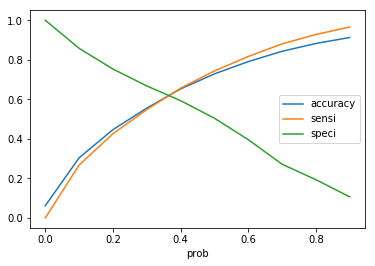

In [110]:
# let's visualize  - Plotting accuracy sensitivity and specificity for all probabilities.
cutoffdf.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [111]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.4 else 0)

In [112]:
#Let's check the overall final accuracy.
metrics.accuracy_score( y_pred_final.churn, y_pred_final.final_predicted)

0.6525321322640888

In [113]:
metrics.confusion_matrix( y_pred_final.churn, y_pred_final.final_predicted )

array([[5606, 2934],
       [ 229,  334]], dtype=int64)

## Building And Evaluating Model, Let's Identifying Important Driver Variables

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance

In [114]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

In [115]:
df_for_boostinf = df_derived

In [116]:
# Removing not required columns
df_for_boostinf = df_for_boostinf.drop(['date_of_last_rech_6','date_of_last_rech_7',
                                        'date_of_last_rech_8','date_of_last_rech_data_6',
                                        'date_of_last_rech_data_7','date_of_last_rech_data_8', 
                                        'aon_group', 'arpu_group_2_mths', 'arpu_group_3_mths', 
                                        'max_rech_amt_group_2_mths', 'total_rech_amt_group_2_mths'],axis=1)

In [117]:
# Putting feature variable to X
X = df_for_boostinf.drop(['churn'],axis=1)

# Putting response variable to y
y = df_for_boostinf['churn']

In [118]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [119]:
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [120]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[0.9960151 , 0.00398495],
       [0.87357605, 0.12642398],
       [0.99567515, 0.00432487],
       [0.32506597, 0.674934  ],
       [0.62755704, 0.372443  ],
       [0.9957082 , 0.0042918 ],
       [0.9408417 , 0.05915835],
       [0.98267734, 0.01732266],
       [0.65120643, 0.34879357],
       [0.9569296 , 0.04307037]], dtype=float32)

In [121]:
# evaluate predictions
import sklearn.metrics as metrics
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("Area under the curve: %.2f%%" % (roc * 100.0))

Area under the curve: 91.01%


In [122]:
# hyperparameter tuning with XGBoost
from sklearn.model_selection import GridSearchCV
# creating 3 Fold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

### Following Funtion takes nearly 6 minutes 
##### System Reference - 8 GB RAM and Intel Core i7 Processor )

In [123]:
# fit the model
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.2, 0.6], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [124]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      12.359360      0.190034         0.078629        0.000712   
1      15.398118      0.343394         0.070935        0.006571   
2      16.388258      0.896853         0.078094        0.012770   
3      12.383145      0.103194         0.077325        0.001105   
4      15.434724      0.300457         0.072553        0.004009   
5      15.777677      0.270401         0.070983        0.001305   

  param_learning_rate param_subsample  \
0                 0.2             0.3   
1                 0.2             0.6   
2                 0.2             0.9   
3                 0.6             0.3   
4                 0.6             0.6   
5                 0.6             0.9   

                                     params  split0_test_score  \
0  {'learning_rate': 0.2, 'subsample': 0.3}           0.884454   
1  {'learning_rate': 0.2, 'subsample': 0.6}           0.890955   
2  {'learning_rate': 0.2, 'subsample': 0.9}           0.897647   
3  {'learning_rate': 0.6, 'subsample': 0.3}           0.841171   
4  {'learning_rate': 0.6, 'subsample': 0.6}           0.861843   
5  {'learning_rate': 0.6, 'subsample': 0.9}           0.872893   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.891810           0.893135         0.889799        0.003819   
1           0.903347           0.907419         0.900573        0.007002   
2           0.906393           0.904458         0.902832        0.003751   
3           0.840302           0.857288         0.846253        0.007811   
4           0.867966           0.880583         0.870130        0.007802   
5           0.884022           0.892827         0.883246        0.008157   

   rank_test_score  split0_train_score  split1_train_score  \
0                3            0.958371            0.957665   
1                2            0.965923            0.966772   
2                1            0.967596            0.966427   
3                6            0.965884            0.960499   
4                5            0.988162            0.987982   
5                4            0.991968            0.992453   

   split2_train_score  mean_train_score  std_train_score  
0            0.957984          0.958006         0.000289  
1            0.964255          0.965650         0.001046  
2            0.965635          0.966553         0.000806  
3            0.958930          0.961771         0.002978  
4            0.987321          0.987821         0.000362  
5            0.992170          0.992197         0.000199

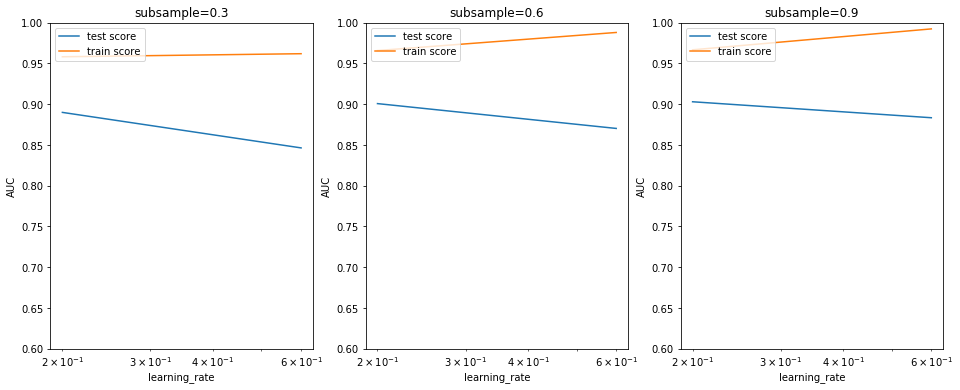

In [125]:
# let's Visualize
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    plt.subplot(1,len(param_grid['subsample']), n+1)
    plot_df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(plot_df["param_learning_rate"], plot_df["mean_test_score"])
    plt.plot(plot_df["param_learning_rate"], plot_df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

For given hyper-parameters
from the above graph it is evident that learning_rate =0.2 and subsample=0.9 which produces a model with higher AUC ( Area Under the curve )with overfitting.
so using those parameters for the final model.

In [126]:
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic',
       params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.9, 'objective': 'binary:logistic'},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [127]:
# predict
#y_pred_actuals was for the predictions interms of churns
#y_pred is for probabilistic predictions used for AUC.
y_pred_actuals = model.predict(X_test)
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[0.9960151 , 0.00398495],
       [0.87357605, 0.12642398],
       [0.99567515, 0.00432487],
       [0.32506597, 0.674934  ],
       [0.62755704, 0.372443  ],
       [0.9957082 , 0.0042918 ],
       [0.9408417 , 0.05915835],
       [0.98267734, 0.01732266],
       [0.65120643, 0.34879357],
       [0.9569296 , 0.04307037]], dtype=float32)

In [128]:
# roc_auc
import sklearn
area_under_curve = sklearn.metrics.roc_auc_score(y_test, y_pred[:, 1])
area_under_curve

0.9100704655970651

AUC is 91 %  #### AUC is an abbrevation for area under the curve. It is used in classification analysis in order to determine which of the used models predicts the classes best


In [129]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

confusion_matrix_test_Data = confusion_matrix(y_test,y_pred_actuals)
print(confusion_matrix(y_test,y_pred_actuals))
total1=sum(sum(confusion_matrix_test_Data))
accuracy1=(confusion_matrix_test_Data[0,0]+confusion_matrix_test_Data[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = confusion_matrix_test_Data[0,0]/(confusion_matrix_test_Data[0,0]+confusion_matrix_test_Data[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = confusion_matrix_test_Data[1,1]/(confusion_matrix_test_Data[1,0]+confusion_matrix_test_Data[1,1])
print('Specificity : ', specificity1)

[[8423  117]
 [ 379  184]]
Accuracy :  0.9455124684170054
Sensitivity :  0.9862997658079625
Specificity :  0.3268206039076377


In [130]:
y_predict_train = model.predict(X_train)

In [131]:
# Confusion matrix sensitivity and specificity for training data
confusion_matrix_train_Data = confusion_matrix(y_train,y_predict_train)
print(confusion_matrix_train_Data)
total2=sum(sum(confusion_matrix_train_Data))
accuracy2=(confusion_matrix_train_Data[0,0]+confusion_matrix_train_Data[1,1])/total2
print ('Accuracy : ', accuracy2)

sensitivity2 = confusion_matrix_train_Data[0,0]/(confusion_matrix_train_Data[0,0]+confusion_matrix_train_Data[0,1])
print('Sensitivity : ', sensitivity2 )

specificity2 = confusion_matrix_train_Data[1,1]/(confusion_matrix_train_Data[1,0]+confusion_matrix_train_Data[1,1])
print('Specificity : ', specificity2)

[[19674   254]
 [  793   519]]
Accuracy :  0.9507062146892655
Sensitivity :  0.987254114813328
Specificity :  0.3955792682926829


### Observation
As we see it from the results - Accuracy, specificity and sensitivity for both train and test data, there wasn't much deviation except for specificity. So we can conclude there is no overfitting.

In [132]:
# let's check feature_importances_ from the model
feature_importance = dict(zip(X_train.columns, model.feature_importances_))
feature_importance

{'mobile_number': 0.0025219012,
 'arpu_6': 0.005444597,
 'arpu_7': 0.0068561276,
 'arpu_8': 0.010853739,
 'onnet_mou_6': 0.0064396877,
 'onnet_mou_7': 0.0,
 'onnet_mou_8': 0.0,
 'offnet_mou_6': 0.0057833344,
 'offnet_mou_7': 0.005425881,
 'offnet_mou_8': 0.0042038797,
 'roam_ic_mou_6': 0.0,
 'roam_ic_mou_7': 0.0067090816,
 'roam_ic_mou_8': 0.018499902,
 'roam_og_mou_6': 0.004412078,
 'roam_og_mou_7': 0.009460246,
 'roam_og_mou_8': 0.0169753,
 'loc_og_t2t_mou_6': 0.00288371,
 'loc_og_t2t_mou_7': 0.010464037,
 'loc_og_t2t_mou_8': 0.005135383,
 'loc_og_t2m_mou_6': 0.0046302783,
 'loc_og_t2m_mou_7': 0.005424061,
 'loc_og_t2m_mou_8': 0.019572046,
 'loc_og_t2f_mou_6': 0.013359452,
 'loc_og_t2f_mou_7': 0.003566007,
 'loc_og_t2f_mou_8': 0.028898887,
 'loc_og_t2c_mou_6': 0.0019678029,
 'loc_og_t2c_mou_7': 0.0033502341,
 'loc_og_t2c_mou_8': 0.010291203,
 'loc_og_mou_6': 0.0014873751,
 'loc_og_mou_7': 0.011022447,
 'loc_og_mou_8': 0.012692819,
 'std_og_t2t_mou_6': 0.0,
 'std_og_t2t_mou_7': 0.0033

In [133]:
import operator
columns_sorted_desc_importance = sorted(feature_importance.items(), key=operator.itemgetter(1),reverse=True)

In [134]:
columns_sorted_desc_importance

[('total_ic_mou_8', 0.08300747),
 ('loc_ic_mou_8', 0.069328904),
 ('fb_user_8', 0.04874769),
 ('av_rech_amt_data_7', 0.035108663),
 ('loc_ic_t2m_mou_8', 0.033103976),
 ('loc_og_t2f_mou_8', 0.028898887),
 ('last_day_rch_amt_8', 0.022734357),
 ('loc_og_t2m_mou_8', 0.019572046),
 ('std_og_mou_7', 0.019319959),
 ('roam_ic_mou_8', 0.018499902),
 ('av_rech_amt_data_8', 0.018009093),
 ('roam_og_mou_8', 0.0169753),
 ('loc_og_t2f_mou_6', 0.013359452),
 ('max_rech_data_7', 0.012762363),
 ('loc_og_mou_8', 0.012692819),
 ('max_rech_data_8', 0.012307109),
 ('total_rech_num_7', 0.012187269),
 ('avg_max_rech_amt', 0.0116527015),
 ('arpu_2g_7', 0.0114441505),
 ('loc_og_mou_7', 0.011022447),
 ('total_ic_mou_7', 0.010890438),
 ('arpu_8', 0.010853739),
 ('total_rech_amt_8', 0.010581813),
 ('loc_og_t2t_mou_7', 0.010464037),
 ('loc_og_t2c_mou_8', 0.010291203),
 ('total_og_mou_8', 0.009791962),
 ('roam_og_mou_7', 0.009460246),
 ('arpu_2_mths', 0.0093544675),
 ('spl_ic_mou_8', 0.008927239),
 ('loc_ic_mou_6',

## Now let's Applying Random Forest 

In [135]:
# Importing from sklearn library
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

# Running with default parameters.
rfc = RandomForestClassifier(class_weight={0:0.9,1:0.9})

In [136]:
# apply fit
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.9, 1: 0.9},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [137]:
# let's predict
predictions = rfc.predict(X_test)

In [138]:
# Importing classification,report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [139]:
# Let's check the report of our default model
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8540
           1       0.59      0.22      0.32       563

   micro avg       0.94      0.94      0.94      9103
   macro avg       0.77      0.61      0.65      9103
weighted avg       0.93      0.94      0.93      9103



In [140]:
# Observing confusion matrix
print(confusion_matrix(y_test,predictions))

[[8453   87]
 [ 438  125]]


In [141]:
#let's see the accuracy
print(accuracy_score(y_test,predictions))

0.9423267054817094


In [142]:
# GridSearchCV - finding optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(2, 20, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=0)

In [143]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.196748      0.017545         0.007580        0.004442   
1       0.572233      0.009040         0.013360        0.002811   
2       0.771891      0.013510         0.008436        0.007093   
3       0.955207      0.015093         0.005511        0.006847   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               2   {'max_depth': 2}           0.938103           0.942104   
1               7   {'max_depth': 7}           0.945164           0.943516   
2              12  {'max_depth': 12}           0.945164           0.941398   
3              17  {'max_depth': 17}           0.944458           0.940692   

   split2_test_score  split3_test_score       ...         mean_test_score  \
0           0.938324           0.938309       ...                0.939266   
1           0.947740           0.944667       ...                0.945245   
2           0.945386           0.943019       ...                0.943974   
3           0.945151           0.942077       ...                0.943362   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.001501                4            0.938261            0.943029   
1        0.001383                1            0.952210            0.951621   
2        0.001538                2            0.975928            0.977400   
3        0.001693                3            0.991054            0.990054   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.938206            0.938210            0.938739   
1            0.951919            0.953157            0.952274   
2            0.975753            0.975519            0.975931   
3            0.987818            0.990584            0.989290   

   mean_train_score  std_train_score  
0          0.939289         0.001880  
1          0.952236         0.000516  
2          0.976106         0.000664  
3          0.989760         0.001134  

[4 rows x 21 columns]

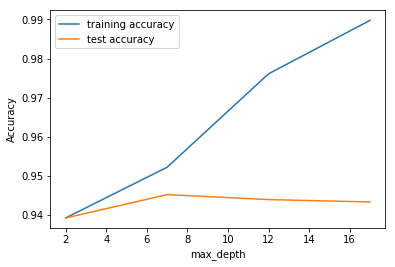

In [144]:
# plot accuracies along with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [145]:
# GridSearchCV to find optimal n_estimators for range 1,10,1
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(1, 10, 1)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(1, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=0)

In [146]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.162134      0.032170         0.007446        0.007025   
1       0.255034      0.030296         0.007320        0.004968   
2       0.384286      0.040253         0.009371        0.007652   
3       0.466269      0.051663         0.006904        0.006069   
4       0.557670      0.037492         0.011360        0.006085   

  param_n_estimators               params  split0_test_score  \
0                  1  {'n_estimators': 1}           0.919040   
1                  2  {'n_estimators': 2}           0.937632   
2                  3  {'n_estimators': 3}           0.936456   
3                  4  {'n_estimators': 4}           0.943281   
4                  5  {'n_estimators': 5}           0.941869   

   split1_test_score  split2_test_score  split3_test_score       ...         \
0           0.901153           0.915725           0.910996       ...          
1           0.934337           0.937618           0.938309       ...          
2           0.933161           0.934793           0.934777       ...          
3           0.938574           0.940678           0.943254       ...          
4           0.940457           0.940443           0.940193       ...          

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.912476        0.006213                9            0.964393   
1         0.937100        0.001407                7            0.973810   
2         0.934793        0.001042                8            0.986581   
3         0.941431        0.001760                5            0.983756   
4         0.940348        0.000981                6            0.992231   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.967395            0.966102            0.968046   
1            0.972221            0.972811            0.972518   
2            0.986346            0.987112            0.985112   
3            0.983638            0.982757            0.983052   
4            0.991054            0.989995            0.990702   

   split4_train_score  mean_train_score  std_train_score  
0            0.968399          0.966867         0.001464  
1            0.974284          0.973129         0.000787  
2            0.985112          0.986052         0.000807  
3            0.982169          0.983074         0.000584  
4            0.990937          0.990984         0.000724  

[5 rows x 21 columns]

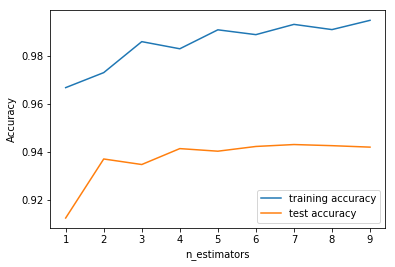

In [147]:
# plot accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [148]:
# GridSearchCV to find max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [10, 25, 50, 75 , 100]} 

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [10, 25, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [149]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.913156      0.022185         0.013397        0.003151   
1       2.484425      0.058767         0.012379        0.002798   
2       5.610217      0.336982         0.015088        0.001061   
3       8.553377      0.381411         0.011440        0.005875   
4      12.269228      0.389844         0.008839        0.007282   

  param_max_features                 params  split0_test_score  \
0                 10   {'max_features': 10}           0.943045   
1                 25   {'max_features': 25}           0.943987   
2                 50   {'max_features': 50}           0.946811   
3                 75   {'max_features': 75}           0.946105   
4                100  {'max_features': 100}           0.941869   

   split1_test_score  split2_test_score  split3_test_score       ...         \
0           0.942104           0.941620           0.944196       ...          
1           0.942339           0.945151           0.939722       ...          
2           0.942810           0.943032           0.942312       ...          
3           0.943045           0.947976           0.942548       ...          
4           0.941398           0.945621           0.942077       ...          

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.942702        0.000883                4            0.992820   
1         0.942938        0.001844                3            0.993055   
2         0.942985        0.002204                2            0.993997   
3         0.944115        0.002561                1            0.993761   
4         0.942561        0.001546                5            0.992055   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.993114            0.993291            0.993350   
1            0.993997            0.993585            0.994763   
2            0.992408            0.993114            0.992821   
3            0.993467            0.992820            0.993586   
4            0.992937            0.993821            0.993998   

   split4_train_score  mean_train_score  std_train_score  
0            0.992938          0.993103         0.000202  
1            0.993409          0.993762         0.000585  
2            0.994115          0.993291         0.000665  
3            0.993115          0.993350         0.000339  
4            0.993115          0.993185         0.000694  

[5 rows x 21 columns]

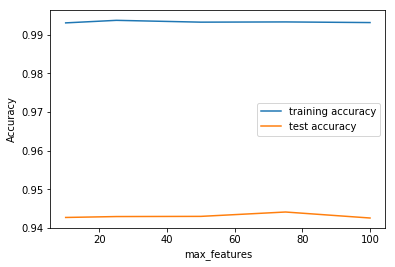

In [150]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [151]:
# Create the parameter grid based on the results of random search  
param_grid = {     'max_depth': [2,4,6],
                   'n_estimators': [1,2,3],
                   'max_features': [5,15,25] } 

# Create a based model 
rf = RandomForestClassifier() 

# Instantiate the grid search 
model_GSV = GridSearchCV(estimator = rf, param_grid = param_grid,cv = 3, n_jobs = -1,verbose = 1) 

# Fit the grid search to the data grid_search.fit(X_train, y_train) 
model_GSV.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    6.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 4, 6], 'n_estimators': [1, 2, 3], 'max_features': [5, 15, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [152]:
print('We can get accuracy of',model_GSV.best_score_,'using',model_GSV.best_params_)

We can get accuracy of 0.9449152542372882 using {'max_depth': 4, 'max_features': 25, 'n_estimators': 3}


In [153]:
# checking with best hyper-parameters from sklearn.ensemble
# Combining models ( ensemble learning )
rfc_ensembled = RandomForestClassifier(bootstrap=True,         max_depth=4,
                                                           max_features=20,
                                                           n_estimators=2,
                                                           class_weight={0:0.9,1:0.9}) 
rfc_ensembled.fit(X_train,y_train) 

RandomForestClassifier(bootstrap=True, class_weight={0: 0.9, 1: 0.9},
            criterion='gini', max_depth=4, max_features=20,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [154]:
# Make predictions
predictions_after_ensemble = rfc_ensembled.predict(X_test)

In [155]:
predictions_after_ensemble

array([0, 0, 0, ..., 0, 0, 0])

In [156]:
print(metrics.classification_report(y_test,predictions_after_ensemble))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8540
           1       0.65      0.17      0.27       563

   micro avg       0.94      0.94      0.94      9103
   macro avg       0.80      0.58      0.62      9103
weighted avg       0.93      0.94      0.93      9103



In [157]:
# Print confusion matrix
print(confusion_matrix(y_test,predictions_after_ensemble))

[[8487   53]
 [ 466   97]]


In [158]:
print(accuracy_score(y_test,predictions_after_ensemble))

0.9429858288476326


In [159]:
import pandas as pd
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [160]:
feature_importances.head(10)

importance
loc_ic_mou_8          0.052111
total_ic_mou_8        0.051688
roam_og_mou_8         0.025401
total_og_mou_8        0.023040
last_day_rch_amt_8    0.018820
roam_ic_mou_8         0.016916
total_rech_amt_8      0.016785
arpu_8                0.015592
loc_og_t2m_mou_8      0.015431
loc_ic_t2t_mou_8      0.013423

In [161]:
import pandas as pd
feature_importances_afterHyPTuning= pd.DataFrame(rfc_ensembled.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_afterHyPTuning.head(10)

importance
loc_ic_t2m_mou_8      0.352070
arpu_8                0.171373
max_rech_data_8       0.092101
roam_ic_mou_8         0.046159
loc_og_t2m_mou_8      0.044691
loc_og_mou_8          0.041769
roam_og_mou_8         0.037036
loc_og_t2f_mou_8      0.032567
last_day_rch_amt_8    0.030453
av_rech_amt_data_7    0.024415

The top 6 features comprising of more than 75% importances are,
1.loc_og_mou_8 2.total_ic_mou_8 3.last_day_rch_amt_8 4.std_ic_mou_8 5.loc_ic_t2m_mou_8 6.roam_og_mou_8

In [162]:
print(max(rfc.feature_importances_))

0.052110909916757056


In [163]:
print(max(rfc_ensembled.feature_importances_))

0.3520701017389072


In [164]:
#Make prediction on the test data
pred_probs_test= rfc_ensembled.predict_proba(X_test)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.86'

In [165]:
y_pred_df = pd.DataFrame(pred_probs_test)
y_pred_df.head()

0
0  0.012050
1  0.279403
2  0.012050
3  0.218508
4  0.064192

In [166]:
y_pred_1 = y_pred_df.iloc[:,[0]]
y_pred_1.head()

0
0  0.012050
1  0.279403
2  0.012050
3  0.218508
4  0.064192

In [167]:
# Converting y_test to df
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

churn
87540      0
88274      1
17428      0
88159      1
92753      0

In [168]:
# Removing index for both df to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True,inplace=True)

In [169]:
y_pred_1.head()

0
0  0.012050
1  0.279403
2  0.012050
3  0.218508
4  0.064192

In [170]:
y_test_df.head()

churn
0      0
1      1
2      0
3      1
4      0

In [171]:
# Appending y_test_df and y_pred_1 df
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)

In [172]:
y_pred_final.head(10)

churn         0
0      0  0.012050
1      1  0.279403
2      0  0.012050
3      1  0.218508
4      0  0.064192
5      0  0.012050
6      0  0.041895
7      0  0.078980
8      0  0.064192
9      0  0.033196

In [173]:
# Renaming the col 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [174]:
# Rearrange the cols
y_pred_final = y_pred_final.reindex_axis(['churn','Churn_Prob'], axis=1)

In [175]:
# Let's see y_pred_final
y_pred_final.head(10)

churn  Churn_Prob
0      0    0.012050
1      1    0.279403
2      0    0.012050
3      1    0.218508
4      0    0.064192
5      0    0.012050
6      0    0.041895
7      0    0.078980
8      0    0.064192
9      0    0.033196

In [176]:
# Create new column 'predicted' with 1 if Churn_Prob grater than 0.5 else 0 
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

In [177]:
# Let's see the head
y_pred_final.head(20)


churn  Churn_Prob  predicted
0       0    0.012050          0
1       1    0.279403          0
2       0    0.012050          0
3       1    0.218508          0
4       0    0.064192          0
5       0    0.012050          0
6       0    0.041895          0
7       0    0.078980          0
8       0    0.064192          0
9       0    0.033196          0
10      0    0.021266          0
11      0    0.012050          0
12      0    0.021266          0
13      0    0.012050          0
14      0    0.041895          0
15      1    0.146931          0
16      0    0.012050          0
17      0    0.012050          0
18      1    0.166164          0
19      0    0.143631          0

In [178]:
# let's see the final Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[8487,   53],
       [ 466,   97]], dtype=int64)

In [179]:
#Let's check the overall/final accuracy.
metrics.accuracy_score( y_pred_final.churn, y_pred_final.predicted)

0.9429858288476326

In [180]:
# Let's create columns with different probability ranges (0 - 0.9)
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  \
0      0    0.012050          0    1    0    0    0    0    0    0    0    0   
1      1    0.279403          0    1    1    1    0    0    0    0    0    0   
2      0    0.012050          0    1    0    0    0    0    0    0    0    0   
3      1    0.218508          0    1    1    1    0    0    0    0    0    0   
4      0    0.064192          0    1    0    0    0    0    0    0    0    0   

   0.9  
0    0  
1    0  
2    0  
3    0  
4    0

In [181]:
# Now let's calculate accuracy sensitivity and specificity for various probability ranges (0 - 0.9)
cutoffdf = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoffdf.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoffdf)

     prob  accuracy     sensi     speci
0.0   0.0  0.061848  0.000000  1.000000
0.1   0.1  0.883884  0.899883  0.641208
0.2   0.2  0.927057  0.956440  0.481350
0.3   0.3  0.939690  0.979040  0.342806
0.4   0.4  0.942546  0.985246  0.294849
0.5   0.5  0.942986  0.993794  0.172291
0.6   0.6  0.942986  0.995199  0.150977
0.7   0.7  0.938152  1.000000  0.000000
0.8   0.8  0.938152  1.000000  0.000000
0.9   0.9  0.938152  1.000000  0.000000


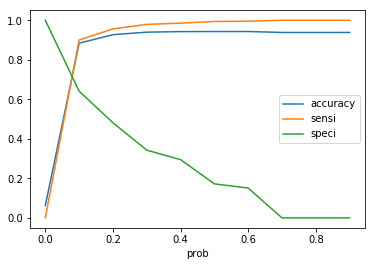

In [182]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoffdf.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [183]:
# let's create a final derived col 'final_predicted'
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.1 else 0)

In [184]:
#Let's check the overall/final accuracy.
metrics.accuracy_score( y_pred_final.churn, y_pred_final.final_predicted)

0.8838844337031748

In [185]:
# Confusion Matrix .. 
metrics.confusion_matrix( y_pred_final.churn, y_pred_final.final_predicted )

array([[7685,  855],
       [ 202,  361]], dtype=int64)

In [186]:
feature_importances_afterHyPTuning= pd.DataFrame(rfc_ensembled.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_afterHyPTuning.head(10)

importance
loc_ic_t2m_mou_8      0.352070
arpu_8                0.171373
max_rech_data_8       0.092101
roam_ic_mou_8         0.046159
loc_og_t2m_mou_8      0.044691
loc_og_mou_8          0.041769
roam_og_mou_8         0.037036
loc_og_t2f_mou_8      0.032567
last_day_rch_amt_8    0.030453
av_rech_amt_data_7    0.024415

### Final Observation

## Evaluating the Models

#### Results with PCA based logistic regression:
Accuracy: 0.65

#### Results with XGBoost model:
Accuracy :  0.9455124684170054
Sensitivity :  0.9862997658079625
Specificity :  0.3268206039076377

#### Results with Random Forest:
Accuracy: 0.9435350983192354

Accuracy is measured using AUC. Based on the confusion matrix and accuracy, the model chosen is XGBoost to identify the churners.

### Churn Indicators 

#### Churn Indicators from XGBoost
In the order of importane (Descending) - Most Important are on 'Top'

1. total_ic_mou_8

2. loc_ic_mou_8

3. fb_user_8

4. av_rech_amt_data_7

5. loc_ic_t2m_mou_8

6. loc_og_t2f_mou_8

7. last_day_rch_amt_8

8. loc_og_t2m_mou_8

9. std_og_mou_7

10. roam_ic_mou_8

#### Churn Indicators identified from Random Forest
In the order of importane (Descending)

1. loc_og_mou_8	

2. total_ic_mou_8	

3. roam_ic_mou_8	

4. total_og_mou_8	

5. loc_ic_mou_8	

6. arpu_8	

7. roam_og_mou_8	

8. total_rech_amt_8	

9. last_day_rch_amt_8	

10. offnet_mou_8	


#### Final Churn Indicators variables

1. total_ic_mou_8

2. loc_ic_t2m_mou_8

3. roam_ic_mou_8

4. av_rech_amt_data_7

5. max_rech_data_7

6. loc_og_t2m_mou_8

7. loc_og_t2t_mou_8

8. loc_og_mou_8

9. roam_ic_mou_7

10. av_rech_amt_data_8

### Fianal Recommendations

1. A high value for roaming incomimng is an indicator for chur hence 'Offering discounted roaming outgoing' packs may retain users.

2. Observe the total recharge amount, give additional talk time with more validity on the recharge amount.

3. Giving discuount for local calls on operator to opertor, within same operator and for operator to mobile. 

4. Give Attractive packages on local outgoing (loc_og_) calls. 

5. Give more discount to the customers who have been with the network for more than an year or less than 3 months.

6. Give additional data on data pack recharges and on Fb_users

7. Provide full talk time on reacharge to increase average revenue per user 

8. If the usage (last recharge amount) is less compared to previous months, speak to the customer to know his concerns.